# Explore the CAZome of _Pectobacterium_ and _Dickeya_ genomes

This notebook explores the size and composition of 200 complete Refseq _Pectobacterium_ and _Dickeya_ CAZomes.

## Table of Contents

0. [Imports](#imports)
    * Load packages
    * Load in data
1. [CAZome size](#cazome-size)
    * Compare the number of CAZymes
    * Compare the proportion of the proteome represented by the CAZomes
2. [CAZy classes](#cazy-classes)
    * The number of CAZymes per CAZy class
    * Mean (+/- SD) number of CAZymes per CAZy class per genus
3. [CAZy families](#cazy-families)
    * Calculate CAZy family frequencies per genome
    * Plot a clustermap of CAZy family frequencies
4. [Core CAZome](#core-cazome)
    * Identify families that are present in all genomes
    * Calculate the frequency of families in the core CAZome
    * [_Pectobacterium_](#pecto-core-cazome) core CAZome
    * [_Dickeya_](#dic-core-cazome)
5. [Always co-occurring families](#co-occurring)
    * Identify CAZy families that are always present in the genome together
    * Explore across all _Pectobacterium_ and _Dickeya_ genomes, and per genus
    * Build an upset plot of co-occurring CAZy families
    * Compile a matrix with the indcidence data for each group of co-occurring CAZy families
6. [Principal Component Analysis (PCA)](#pca)
    * Explore the association between the host range, global distribution and composition of the CAZome
    * Explore across all _Pectobacterium_ and _Dickeya_ genomes, and per genus

<a id="imports"></a>
## 0. Imports

### Packages

In [1]:
!pip3 install adjusttext
!pip3 install -e /home/emmah/eastbio_storage/cazomevolve_dev/

Obtaining file:///home/emmah/eastbio_storage/cazomevolve_dev
  Preparing metadata (setup.py) ... done


  Attempting uninstall: cazomevolve
    Found existing installation: cazomevolve 0.0.4
    Uninstalling cazomevolve-0.0.4:
      Successfully uninstalled cazomevolve-0.0.4
  Running setup.py develop for cazomevolve


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

from copy import copy
from matplotlib.patches import Patch
from pathlib import Path
import upsetplot
import adjustText
import upsetplot

from Bio import SeqIO
from saintBioutils.utilities.file_io.get_paths import get_file_paths
from saintBioutils.utilities.file_io import make_output_directory
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

%matplotlib inline

In [3]:
# loading and parsing data
from cazomevolve.cazome.explore.parse_data import (
    load_fgp_data,
    load_tax_data,
    add_tax_data_from_tax_df,
    add_tax_column_from_row_index,
)

# functions for exploring the sizes of CAZomes
from cazomevolve.cazome.explore.cazome_sizes import (
    calc_proteome_representation,
    count_items_in_cazome,
    get_proteome_sizes,
)

# explore the frequency of CAZymes per CAZy class
from cazomevolve.cazome.explore.cazy_classes import calculate_class_sizes

# explore the frequencies of CAZy families and identify the co-cazome
from cazomevolve.cazome.explore.cazy_families import (
    build_fam_freq_df,
    build_row_colours,
    build_family_clustermap,
    identify_core_cazome,
    plot_fam_boxplot,
    build_fam_mean_freq_df,
    get_group_specific_fams,
    build_family_clustermap_multi_legend,
)

# functions to identify and explore CAZy families that are always present together
from cazomevolve.cazome.explore.cooccurring_families import (
    identify_cooccurring_fams_corrM,
    calc_cooccuring_fam_freqs,
    identify_cooccurring_fam_pairs,
    add_to_upsetplot_membership,
    build_upsetplot,
    get_upsetplot_grps,
    add_upsetplot_grp_freqs,
    build_upsetplot_matrix,
)

# functions to perform PCA
from cazomevolve.cazome.explore.pca import (
    perform_pca,
    plot_explained_variance,
    plot_scree,
    plot_pca,
)

### Data 

**CAZy family annotations: The GFP file**

Load tab delimited list of cazy families, genomes and protein accessions, by providing the path to the 'gfp file' to `load_gfp_data()`.

Each unique protein-family pair is represented on a separate line. Owing to a protein potentially containing multiple CAZyme domains and thus can be annotated with multiple CAZy families, a single protein can be present on multiple rows in the `gfp_df`.

In [4]:
fgp_file = "../data/pecto_dict/cazomes/pd_fam_genomes_proteins"
fgp_df = load_fgp_data(fgp_file)
fgp_df.head(3)

Family           Genome         Protein
0    GH8  GCF_000365365.1  WP_024104087.1
1   GT51  GCF_000365365.1  WP_024104265.1
2   GH32  GCF_000365365.1  WP_024104299.1

In [5]:
len(set(fgp_df['Protein']))

10885

**Taxonomy data:**

Load in CSV of tax data from generated by `cazevolve_add_taxs`, by providing a path to the file to `load_tax_data()`, and specify which tax ranks (kingdom, phylum, etc.) are included in the CSV file.

In [6]:
help(load_tax_data)

Help on function load_tax_data in module cazomevolve.cazome.explore.parse_data:

load_tax_data(tax_csv_path, kingdom=False, phylum=False, tax_class=False, tax_order=False, tax_family=False, genus=False, species=False)
    Load tax data compiled by cazomevolve into a pandas df
    
    :param tax_csv_path: str/Path to csv file of genome, tax_rank, tax_rank
        e.g. 'Genome', 'Genus', 'Species'
    The remaining params are bool checks for lineage ranks included in the tax data file
    
    Return df of genome, tax_rank, tax_rank,  e.g. 'Genome', 'Genus', 'Species'



In [7]:
tax_csv_path = "../data/pecto_dict/cazomes/fg_genome_taxs.csv"
tax_df = load_tax_data(tax_csv_path, genus=True, species=True)
tax_df.head(3)

Genome           Genus       Species
0  GCF_015277635.1  Pectobacterium    aroidearum
1  GCF_016944315.1  Pectobacterium   brasiliense
2  GCF_007210685.1         Dickeya  chrysanthemi

**Compile all data into a single dataframe:**

Build dataframe of:
* CAZy family annotations
* Genomic accession
* Taxonomic infomration - splitting each taxonomy rank (i.e. ranks) into a separate column. E.g.:
    * Genus
    * Species

In [8]:
fgp_df = add_tax_data_from_tax_df(
    fgp_df,
    tax_df,
    genus=True,
    species=True,
)
fgp_df.head(3)

Family           Genome         Protein    Genus      Species
0    GH8  GCF_000365365.1  WP_024104087.1  Dickeya  dianthicola
1   GT51  GCF_000365365.1  WP_024104265.1  Dickeya  dianthicola
2   GH32  GCF_000365365.1  WP_024104299.1  Dickeya  dianthicola

<a id="cazome-size"> </a>
## 1. CAZome size

Calculate the number of CAZymes per genome (defined as the number of unique protein accessions per genome).

In total, calculate:
* The number of CAZymes per genome
* The mean number of CAZymes per genome per genus
* The proportion of the proteome represented by the CAZome
* The mean proportion of the proteome represented by the CAZome

Use the `count_items_in_cazome()` function to retrieve the number of CAZymes and the number of CAZy families per genome, and the mean counts per genus.

In [9]:
help(count_items_in_cazome)

Help on function count_items_in_cazome in module cazomevolve.cazome.explore.cazome_sizes:

count_items_in_cazome(gfp_df, item, grp, round_by=None)
    Count the number of unique items per genome and per specificed tax grouping
    
    :param gfp_df: panda df, cols = ['Family', 'Genome', 'Protein', 'tax grp', 'tax grp'...]
    :param item: str, name of column to calculate incidence for, e.g. 'Protein' or 'Family'
    :param grp: str, name of column to group genomes by
    :param round_by: int, number of figures to round mean and sd by. If None do not round
    
    Return
    * dict of {grp: {genome: {'items': {items}, 'numOfItems': int(num of items)}}}
    * df, cols = []



In [10]:
# Calculate CAZymes per genome
cazome_sizes_dict, cazome_sizes_df = count_items_in_cazome(fgp_df, 'Protein', 'Genus', round_by=2)
cazome_sizes_df

Gathering CAZy families per genome: 100%|██████████| 28371/28371 [00:03<00:00, 9113.96it/s]
Calculating num of Protein per genome and per Genus: 100%|██████████| 3/3 [00:00<00:00, 2482.33it/s]


Genus  MeanProteins  SdProteins  NumOfGenomes
0         Dickeya         98.93        6.55            92
1  Pectobacterium         97.62        6.01           188
2          Hafnia         75.00        0.00             1

In [11]:
# Calculate CAZy families per genome
cazome_fam_dict, cazome_fams_df = count_items_in_cazome(fgp_df, 'Family', 'Genus', round_by=2)
cazome_fams_df

Gathering CAZy families per genome: 100%|██████████| 28371/28371 [00:03<00:00, 9171.00it/s]
Calculating num of Family per genome and per Genus: 100%|██████████| 3/3 [00:00<00:00, 2907.33it/s]


Genus  MeanFamilys  SdFamilys  NumOfGenomes
0         Dickeya        53.09       2.66            92
1  Pectobacterium        54.32       2.41           188
2          Hafnia        40.00       0.00             1

Identify the total number of CAZymes

In [12]:
print(f"The total number of CAZymes is {len(set(fgp_df['Protein']))}")

# exclude the Hafnia genome because it is an outgroup for the phylotree
pd_gf_df = fgp_df[fgp_df['Genus'] != 'Hafnia']
print(f"The total number of Pectobacterium and Dickeya CAZymes is {len(set(pd_gf_df['Protein']))}")

p_gf_df = fgp_df[fgp_df['Genus'] == 'Pectobacterium']
print(f"The total number of Pectobacterium CAZymes is {len(set(p_gf_df['Protein']))}")

d_gf_df = fgp_df[fgp_df['Genus'] == 'Dickeya']
print(f"The total number of Dickeya CAZymes is {len(set(d_gf_df['Protein']))}")

The total number of CAZymes is 10885
The total number of Pectobacterium and Dickeya CAZymes is 10810
The total number of Pectobacterium CAZymes is 7525
The total number of Dickeya CAZymes is 3286


In [13]:
# Get the size of the proteome (the number of protein acc) per genome
grp = 'Genus'
proteome_dir = "/home/emmah/eastbio_storage/eastbio_pecto_dickeya/proteomes"
proteome_dict = get_proteome_sizes(proteome_dir, fgp_df, grp)

Getting proteome sizes: 100%|██████████| 281/281 [00:15<00:00, 17.89it/s]


In [14]:
# Calculate the mean proteome size by genus and the proportion of the proteome represented by the CAZome
proteome_perc_df = calc_proteome_representation(proteome_dict, cazome_sizes_dict, grp, round_by=2)
proteome_perc_df

Calc proteome perc: 100%|██████████| 3/3 [00:00<00:00, 1362.38it/s]


Genus  MeanProteomeSize  SdProteomeSize  MeanProteomePerc   
0         Dickeya           4102.53          142.95              2.41  \
1  Pectobacterium           4207.19          189.81              2.32   
2          Hafnia           4297.00            0.00              1.75   

   SdProteomePerc  NumOfGenomes  
0            0.09            92  
1            0.09           188  
2            0.00             1

Calculate the CAZyme to CAZy family ratio.

In [15]:
cazome_fams_df

Genus  MeanFamilys  SdFamilys  NumOfGenomes
0         Dickeya        53.09       2.66            92
1  Pectobacterium        54.32       2.41           188
2          Hafnia        40.00       0.00             1

In [16]:
cazome_sizes_df['MeanProteins'] / cazome_fams_df['MeanFamilys']

0    1.863439
1    1.797128
2    1.875000
dtype: float64

In [17]:
cazome_sizes_df['SdProteins'] / cazome_fams_df['SdFamilys']

0    2.462406
1    2.493776
2         NaN
dtype: float64

<a id="cazy-classes"> </a>
## 2. CAZy classes

Calculate the number of CAZymes (identified as the number of unique protein accessions) per CAZy class. Also, calculate the mean size of CAZy classes (i.e. the mean number of unique protein accessions per CAZy class in each genome) per genus.

The results are added to a dataframe, which is written to `results/pecto_dic/cazy_class_sizes.csv`, and was used to generate a proportiona area plot using [RawGraphs](https://app.rawgraphs.io/).

In [18]:
# make output dir for results, will not delete data if dir already exists
make_output_directory(Path('../results/pecto_dic'), force=True, nodelete=True)
make_output_directory(Path('../results/pecto_dic/cazy_classes/'), force=True, nodelete=True)

class_df, class_size_dict = calculate_class_sizes(fgp_df, 'Genus', round_by=2)
filtered_class_df = class_df[class_df['Genus'] != 'Hafnia']
filtered_class_df.to_csv('../results/pecto_dic/cazy_classes/cazy_class_sizes.csv')
class_df

Output directory ../results/pecto_dic exists, nodelete is True. Adding output to output directory.
Output directory ../results/pecto_dic/cazy_classes exists, nodelete is True. Adding output to output directory.
Calculating CAZy class sizes: 100%|██████████| 6/6 [00:00<00:00, 560.29it/s]


CAZyClass           Genus  MeanCazyClass  SdCazyClass  MeanClassPerc   
0         GH  Pectobacterium          47.41         2.83          48.61  \
1         GH          Hafnia          41.00         0.00          54.67   
2         GH         Dickeya          41.18         3.56          41.61   
3         GT  Pectobacterium          28.06         3.02          28.70   
4         GT          Hafnia          31.00         0.00          41.33   
5         GT         Dickeya          35.34         2.69          35.77   
6         PL  Pectobacterium          14.17         1.28          14.52   
7         PL          Hafnia           1.00         0.00           1.33   
8         PL         Dickeya          15.53         1.72          15.68   
9         CE  Pectobacterium           6.59         0.85           6.74   
10        CE          Hafnia           3.00         0.00           4.00   
11        CE         Dickeya           6.00         0.69           6.06   
12        AA  Pectobacterium           1.00         0.00           1.05   
13        AA          Hafnia           0.00         0.00           0.00   
14        AA         Dickeya           1.00         0.00           1.26   
15       CBM  Pectobacterium           5.07         0.81           5.19   
16       CBM          Hafnia           3.00         0.00           4.00   
17       CBM         Dickeya           2.43         0.77           2.44   

    SdClassPerc  NumOfGenomes  
0          1.89           188  
1          0.00             1  
2          1.97            92  
3          2.00           188  
4          0.00             1  
5          2.43            92  
6          1.06           188  
7          0.00             1  
8          1.41            92  
9          0.72           188  
10         0.00             1  
11         0.57            92  
12         0.02             2  
13         0.00             1  
14         0.02             2  
15         0.73           188  
16         0.00             1  
17         0.69            92

<a id="cazy-families"> </a>
## 3. CAZy families

### CAZy family frequency dataframe

Calculate the number of CAZymes per CAZy family presented in each genome, where the number of CAZymes is the number of unqiue protein accessions. This value may be greater than the number of CAZymes in the genome because a CAZyme may be annotated with multiple CAZy families.

In [19]:
fam_freq_df = build_fam_freq_df(fgp_df, ['Genus', 'Species'])
make_output_directory(Path('../results/pecto_dic/cazy_families/'), force=True, nodelete=True)
fam_freq_df.to_csv("../results/pecto_dic/cazy_families/cazy_fam_freqs.csv")
fam_freq_df

The dataset contains 90 CAZy families


Counting fam frequencies: 100%|██████████| 281/281 [00:17<00:00, 16.11it/s]
Output directory ../results/pecto_dic/cazy_families exists, nodelete is True. Adding output to output directory.


Genome           Genus      Species  AA10  AA3  CBM13  CBM3   
0    GCF_016864935.1  Pectobacterium  parmentieri     0    0      1     1  \
1    GCF_000365365.1         Dickeya  dianthicola     0    0      0     0   
2    GCF_003932035.1  Pectobacterium  carotovorum     0    0      1     0   
3    GCF_016864995.1  Pectobacterium  carotovorum     0    0      0     0   
4    GCF_003402555.1  Pectobacterium  carotovorum     0    0      1     0   
..               ...             ...          ...   ...  ...    ...   ...   
276  GCF_016949875.1  Pectobacterium  brasiliense     0    0      1     1   
277  GCF_016949195.1  Pectobacterium  brasiliense     0    0      1     0   
278  GCF_003668715.1          Hafnia        alvei     0    0      0     0   
279  GCF_003571485.1  Pectobacterium  carotovorum     0    0      0     0   
280  GCF_016949955.1  Pectobacterium  carotovorum     0    0      1     0   

     CBM32  CBM34  CBM4  ...  PL1  PL10  PL11  PL17  PL2  PL22  PL26  PL3   
0        1      0     0  ...    5     0     0     0    1     1     1    1  \
1        0      0     0  ...    6     0     0     0    0     1     0    2   
2        1      0     0  ...    6     0     0     0    2     1     1    2   
3        1      0     0  ...    6     0     0     0    2     1     1    2   
4        1      0     0  ...    6     0     0     0    2     1     1    2   
..     ...    ...   ...  ...  ...   ...   ...   ...  ...   ...   ...  ...   
276      1      0     0  ...    6     0     0     0    2     1     0    2   
277      1      0     0  ...    6     0     0     0    2     1     0    2   
278      0      1     0  ...    0     0     0     1    0     0     0    0   
279      1      0     0  ...    6     0     0     0    2     1     1    2   
280      1      0     0  ...    6     0     0     0    2     1     1    2   

     PL4  PL9  
0      1    2  
1      1    3  
2      1    2  
3      1    2  
4      1    2  
..   ...  ...  
276    1    2  
277    1    2  
278    0    0  
279    1    2  
280    1    2  

[281 rows x 93 columns]

### Clustermaps

Build clustermap of CAZy family frequencies, with additional row colours marking the genus classification of each genome (i.e. each row).

**Prepare the dataframe of CAZy family frequencies:**

In this case, also exclude the _Hafnia_ genome because it was used as an out group for the phylogenetic tree.

In [20]:
# Drop Hafnia genome
fam_freq_df_pd = copy(fam_freq_df)
fam_freq_df_pd = fam_freq_df_pd[fam_freq_df_pd['Genus'] != 'Hafnia']
fam_freq_df_pd.head(1)

Genome           Genus      Species  AA10  AA3  CBM13  CBM3   
0  GCF_016864935.1  Pectobacterium  parmentieri     0    0      1     1  \

   CBM32  CBM34  CBM4  ...  PL1  PL10  PL11  PL17  PL2  PL22  PL26  PL3  PL4   
0      1      0     0  ...    5     0     0     0    1     1     1    1    1  \

   PL9  
0    2  

[1 rows x 93 columns]

Additionally, index `fam_freq_df` so that each row name contains the genome, Genus and Species, so that the genomic accession, genus and species is included in the clustermap.

In [21]:
# index the taxonomy data and genome (ggs=genome_genus_species)
fam_freq_df_ggs = copy(fam_freq_df_pd)  # so does not alter fam_freq_df
fam_freq_df_ggs = fam_freq_df_ggs.set_index(['Genome','Genus','Species'])
fam_freq_df_ggs.head(1)

AA10  AA3  CBM13  CBM3  CBM32   
Genome          Genus          Species                                      
GCF_016864935.1 Pectobacterium parmentieri     0    0      1     1      1  \

                                            CBM34  CBM4  CBM48  CBM5  CBM63   
Genome          Genus          Species                                        
GCF_016864935.1 Pectobacterium parmentieri      0     0      2     0      1  \

                                            ...  PL1  PL10  PL11  PL17  PL2   
Genome          Genus          Species      ...                               
GCF_016864935.1 Pectobacterium parmentieri  ...    5     0     0     0    1  \

                                            PL22  PL26  PL3  PL4  PL9  
Genome          Genus          Species                                 
GCF_016864935.1 Pectobacterium parmentieri     1     1    1    1    2  

[1 rows x 90 columns]

**Colour scheme:**

Define a colour scheme to colour code the rows by, in this case by the genus of the species.

To do this, add a column containing the data to be used to colour code each row, e.g. a genus. This extra column is removed by `build_row_colours()`. The dataframe that is parsed to `build_row_colours()` must be the dataframe that is used to generate a clustermap, otherwise Seaborn will not be able to map the row oclours correctly and no row colours will be produced.

In [22]:
# define a colour scheme to colour code rows by genus
fam_freq_df_ggs['Genus'] = list(fam_freq_df_pd['Genus'])  # add column to use for colour scheme, is removed
fam_freq_genus_row_colours, fam_g_lut = build_row_colours(fam_freq_df_ggs, 'Genus', 'Set2')

**Build a clustermap of CAZy family frequencies:**

Use the function `build_family_clustermap()` from `cazomevolve` to build clustermaps of the CAZy family frequencies, with different combinations of additional row colours. For example, the row colours could list the genus and/or species classification of each genome.

In [23]:
help(build_family_clustermap)

Help on function build_family_clustermap in module cazomevolve.cazome.explore.cazy_families:

build_family_clustermap(df, row_colours=None, fig_size=None, file_path=None, file_format='png', font_scale=1, dpi=300, dendrogram_ratio=None, lut=None, legend_title='', title_fontsize='2', legend_fontsize='2', bbox_to_anchor=(1, 1), cmap=<matplotlib.colors.ListedColormap object at 0x7f676457d460>, cbar_pos=(0.02, 0.8, 0.05, 0.18))
    Build a clustermap of the CAZy family frequencies per genome
    
    :param df: df of CAZy family frequencies per genome
    :param row_colours: pandas map - used to define additional row colours. or list of maps for 
        multiple sets of row colours. If None, additional row colours are not plotted
    :param fig_size: tuple (width, height) of final figure. If None, decided by Seaborn
    :param file_path: path to save image to. If None, the figure is not written to a file
    :param file_format: str, file format to save figure to. Default 'png'
    :param f

/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


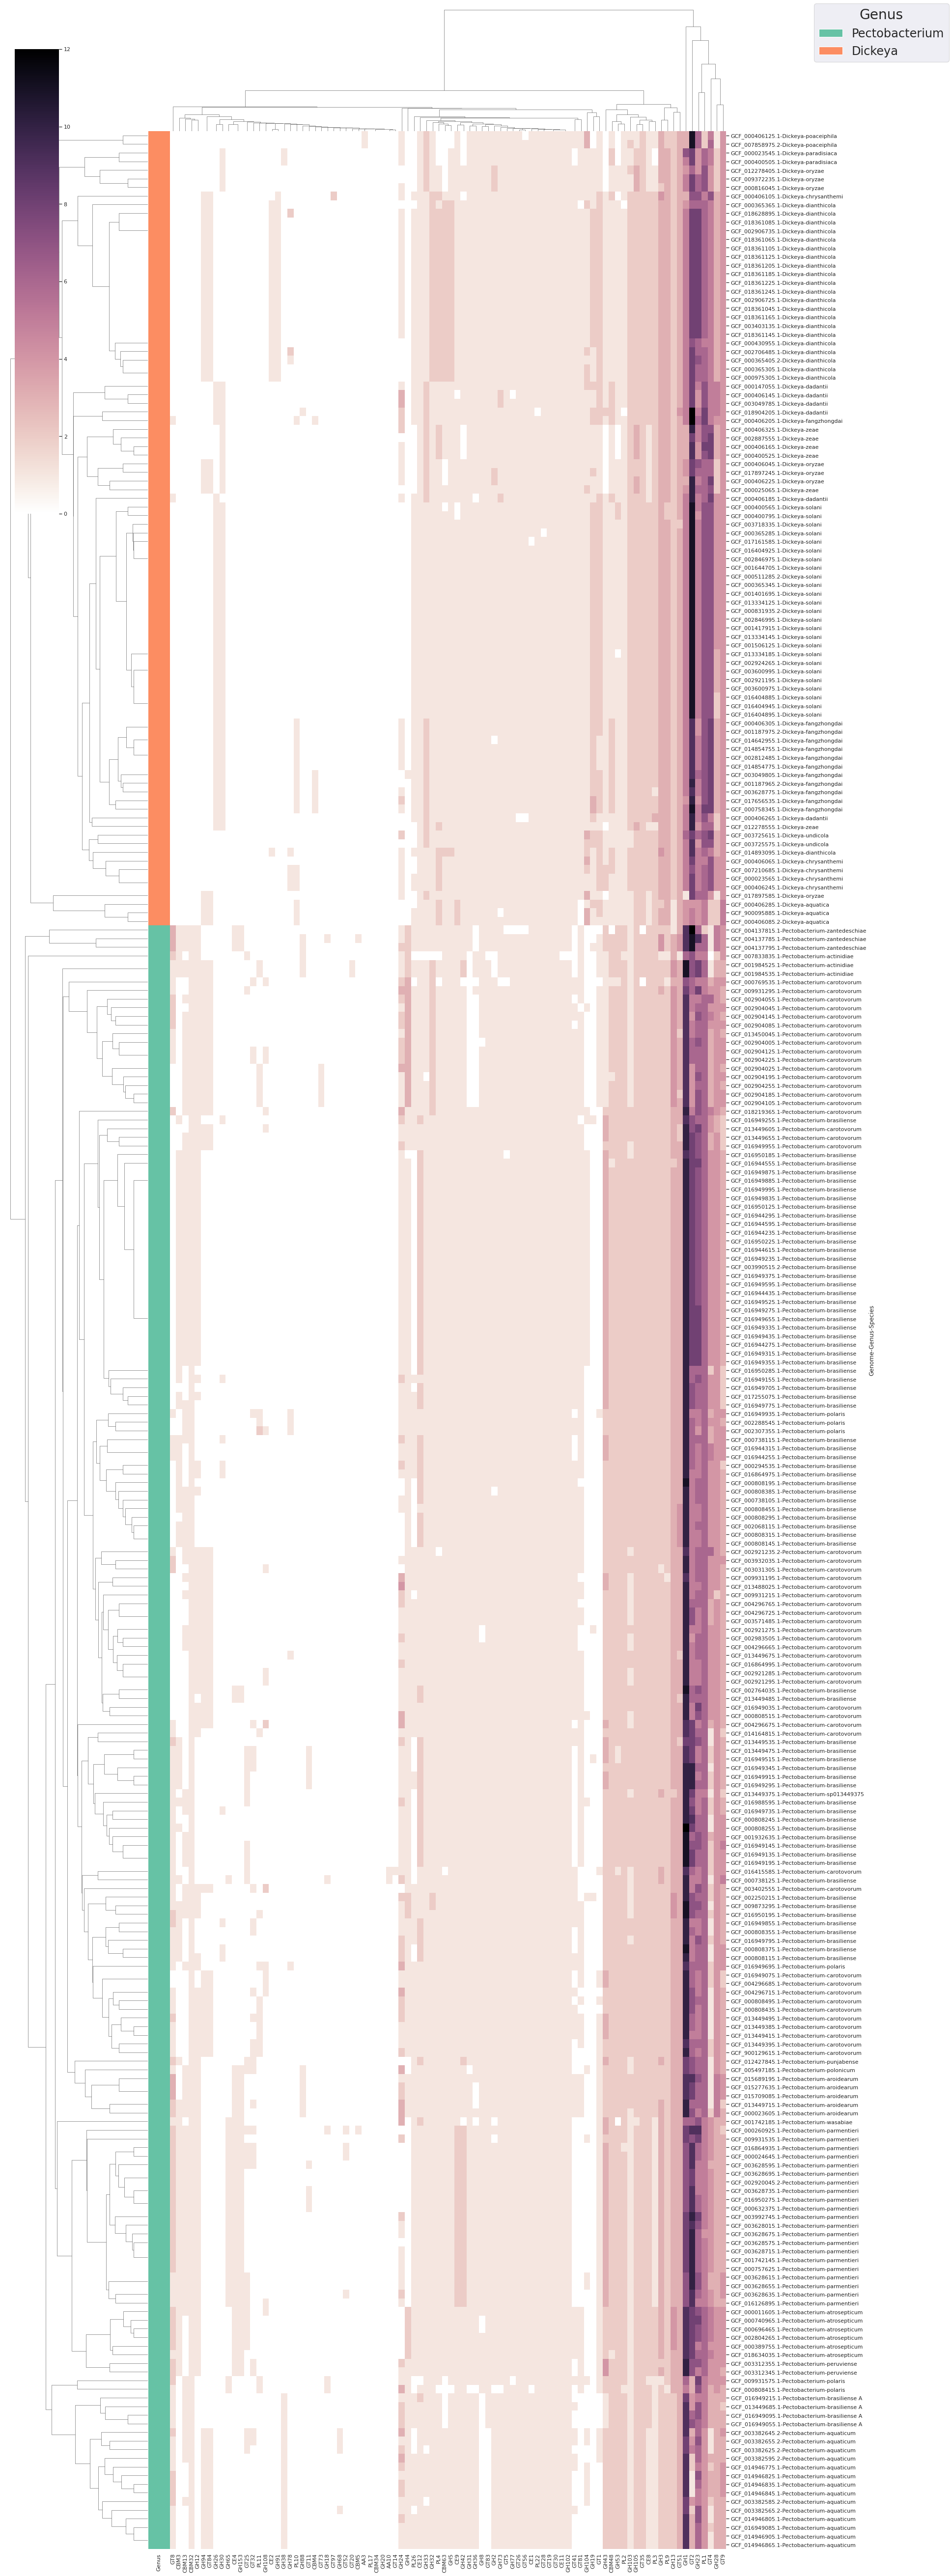

In [24]:
# make a figure that is full size, and all data is legible
build_family_clustermap(
    fam_freq_df_ggs,
    row_colours=fam_freq_genus_row_colours,
    fig_size=(25,73),
    file_path="../results/pecto_dic/cazy_families/pd_fam_freq_clustermap.svg",
    file_format='svg',
    lut=fam_g_lut,
    legend_title='Genus',
    dendrogram_ratio=(0.2,0.05),
    title_fontsize=28,
    legend_fontsize=24,
)

/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


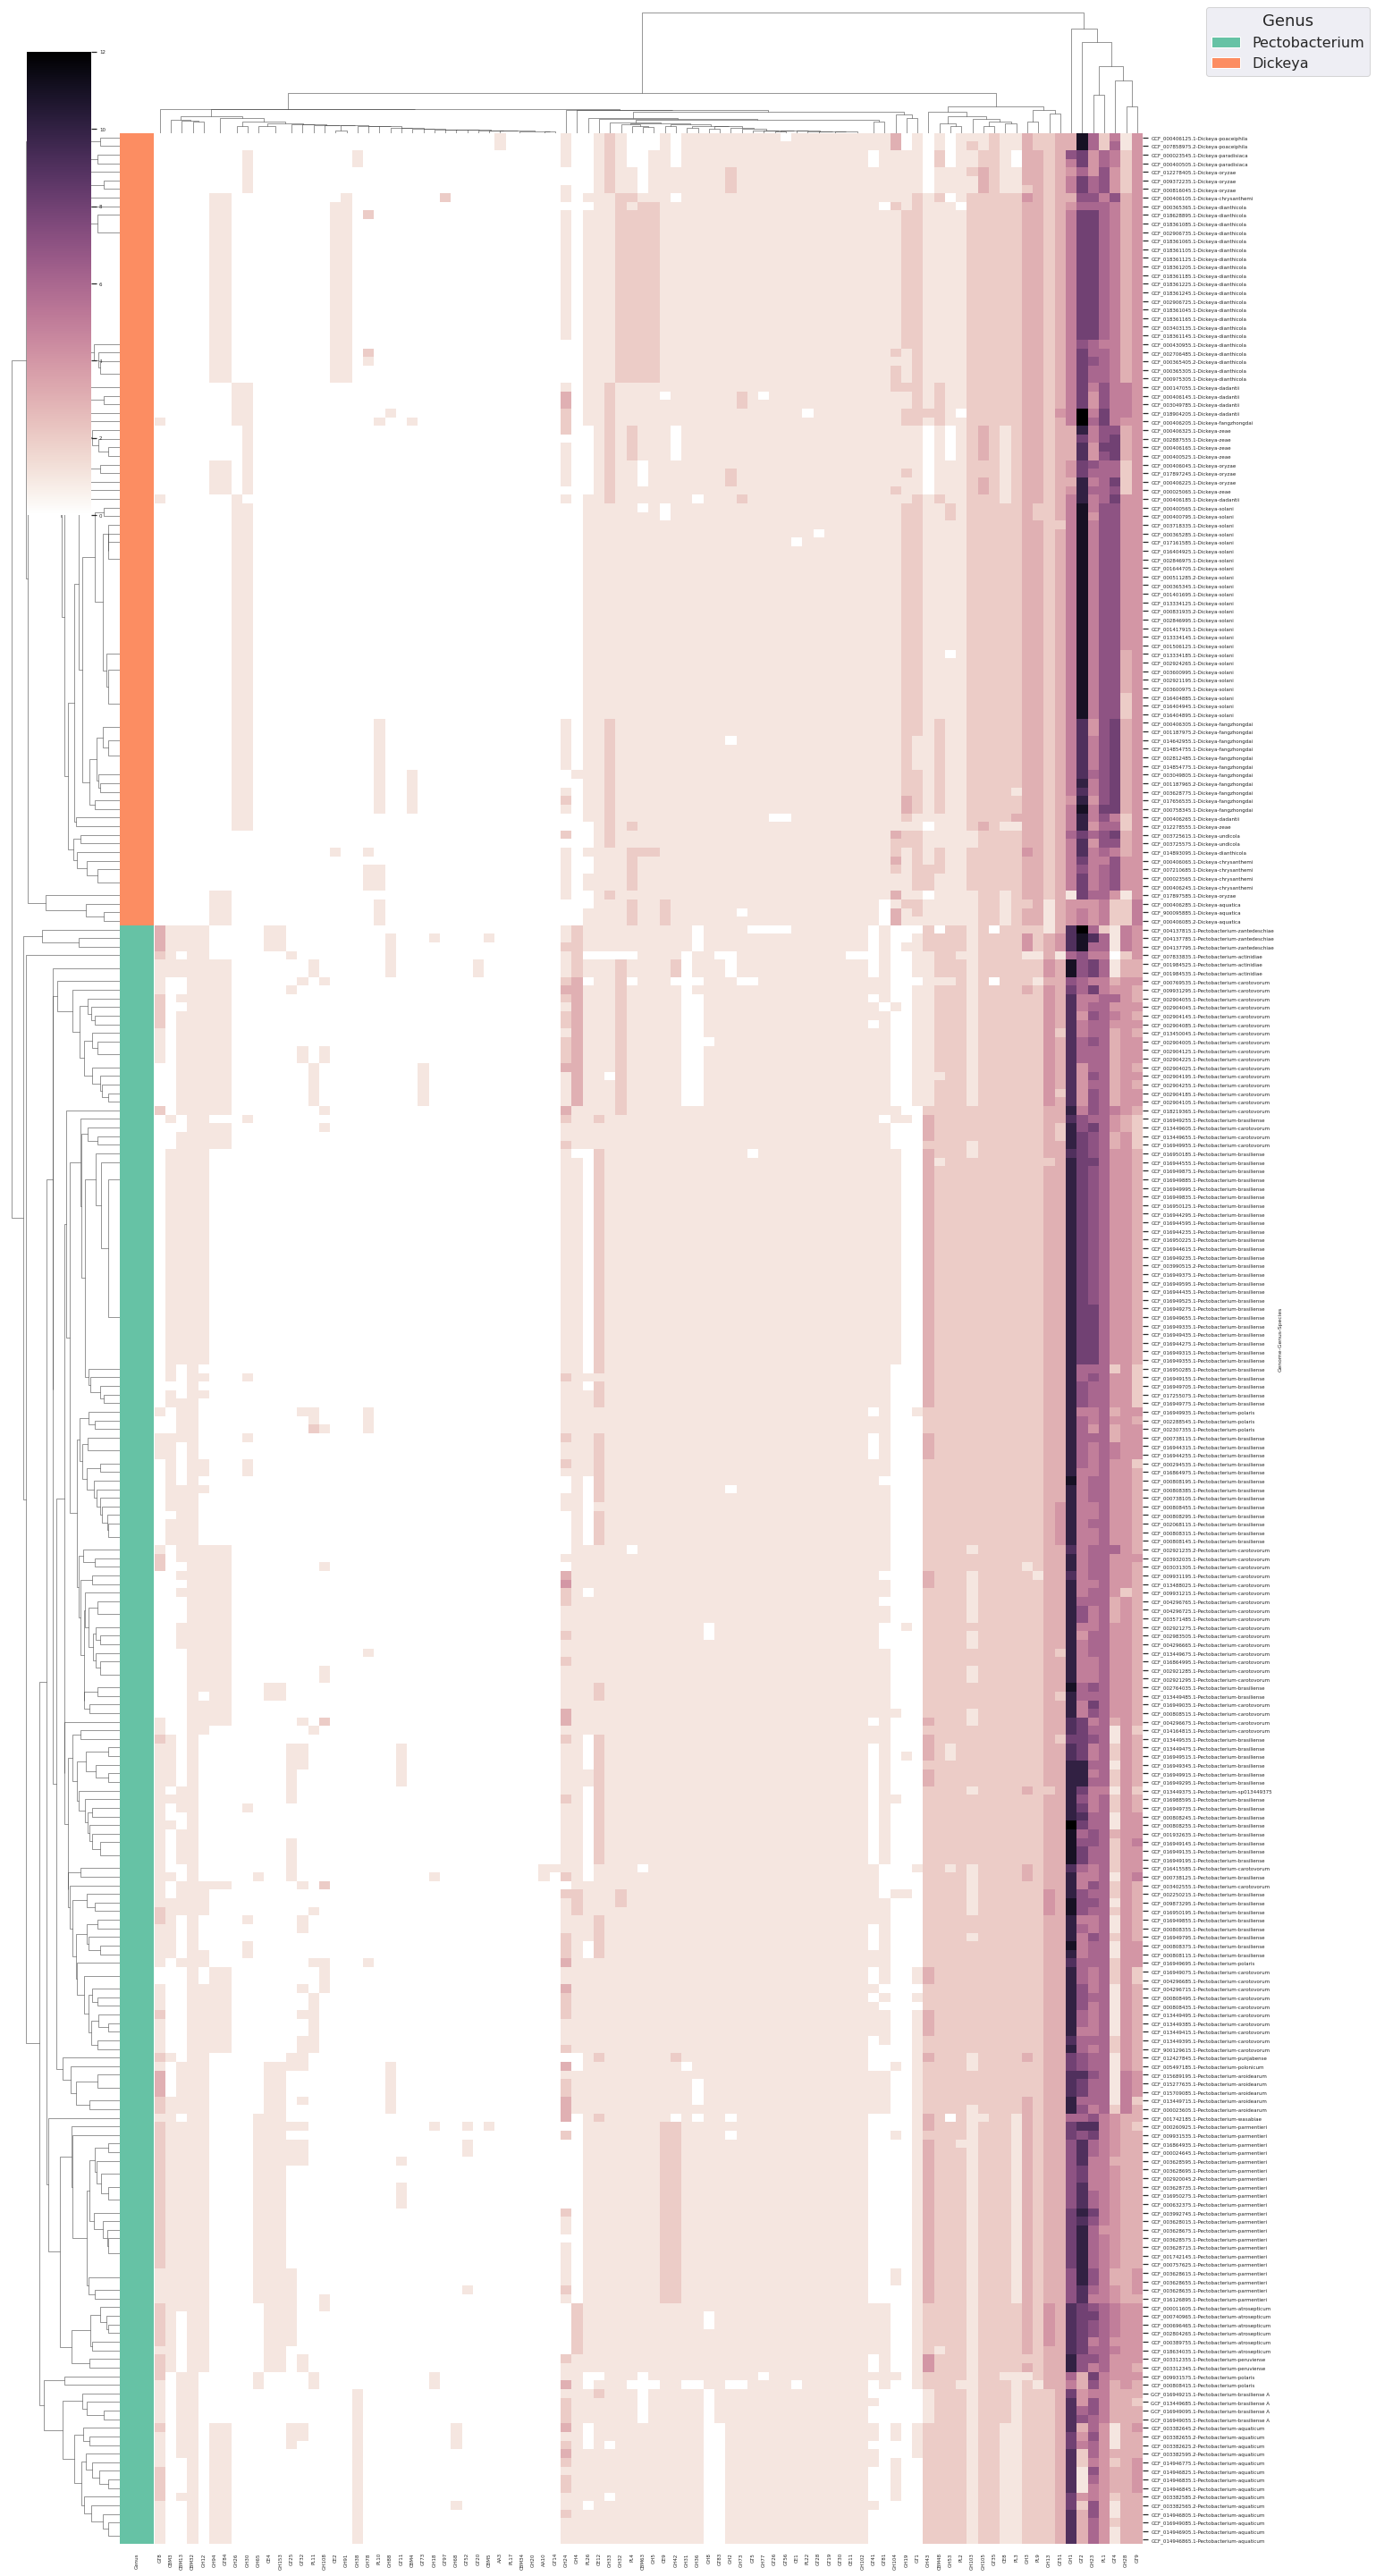

In [25]:
# make a figure the optimal size to fit in a paper
build_family_clustermap(
    fam_freq_df_ggs,
    row_colours=fam_freq_genus_row_colours,
    fig_size=(20,40),
    file_path="../results/pecto_dic/cazy_families/paper_pd_fam_freq_clustermap.png",
    file_format='png',
    font_scale=0.5,
    lut=fam_g_lut,
    legend_title='Genus',
    dendrogram_ratio=(0.1,0.05),
    title_fontsize=18,
    legend_fontsize=16,
)

### Add species classifications

Looking at the species names in the clustermap, there appears to be clustering of the genomes in a manner that correlates not only with their genus classificaiton but also their species classification. Therefore, add an additional row of row-colours, marking the species classification of each genome.

In [26]:
# define a colour scheme to colour code rows by SPECIES
fam_freq_df_ggs['Species'] = list(fam_freq_df_pd['Species'])  # add column to use for colour scheme, is removed
fam_freq_species_row_colours, fam_s_lut = build_row_colours(fam_freq_df_ggs, 'Species', 'rainbow')

/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


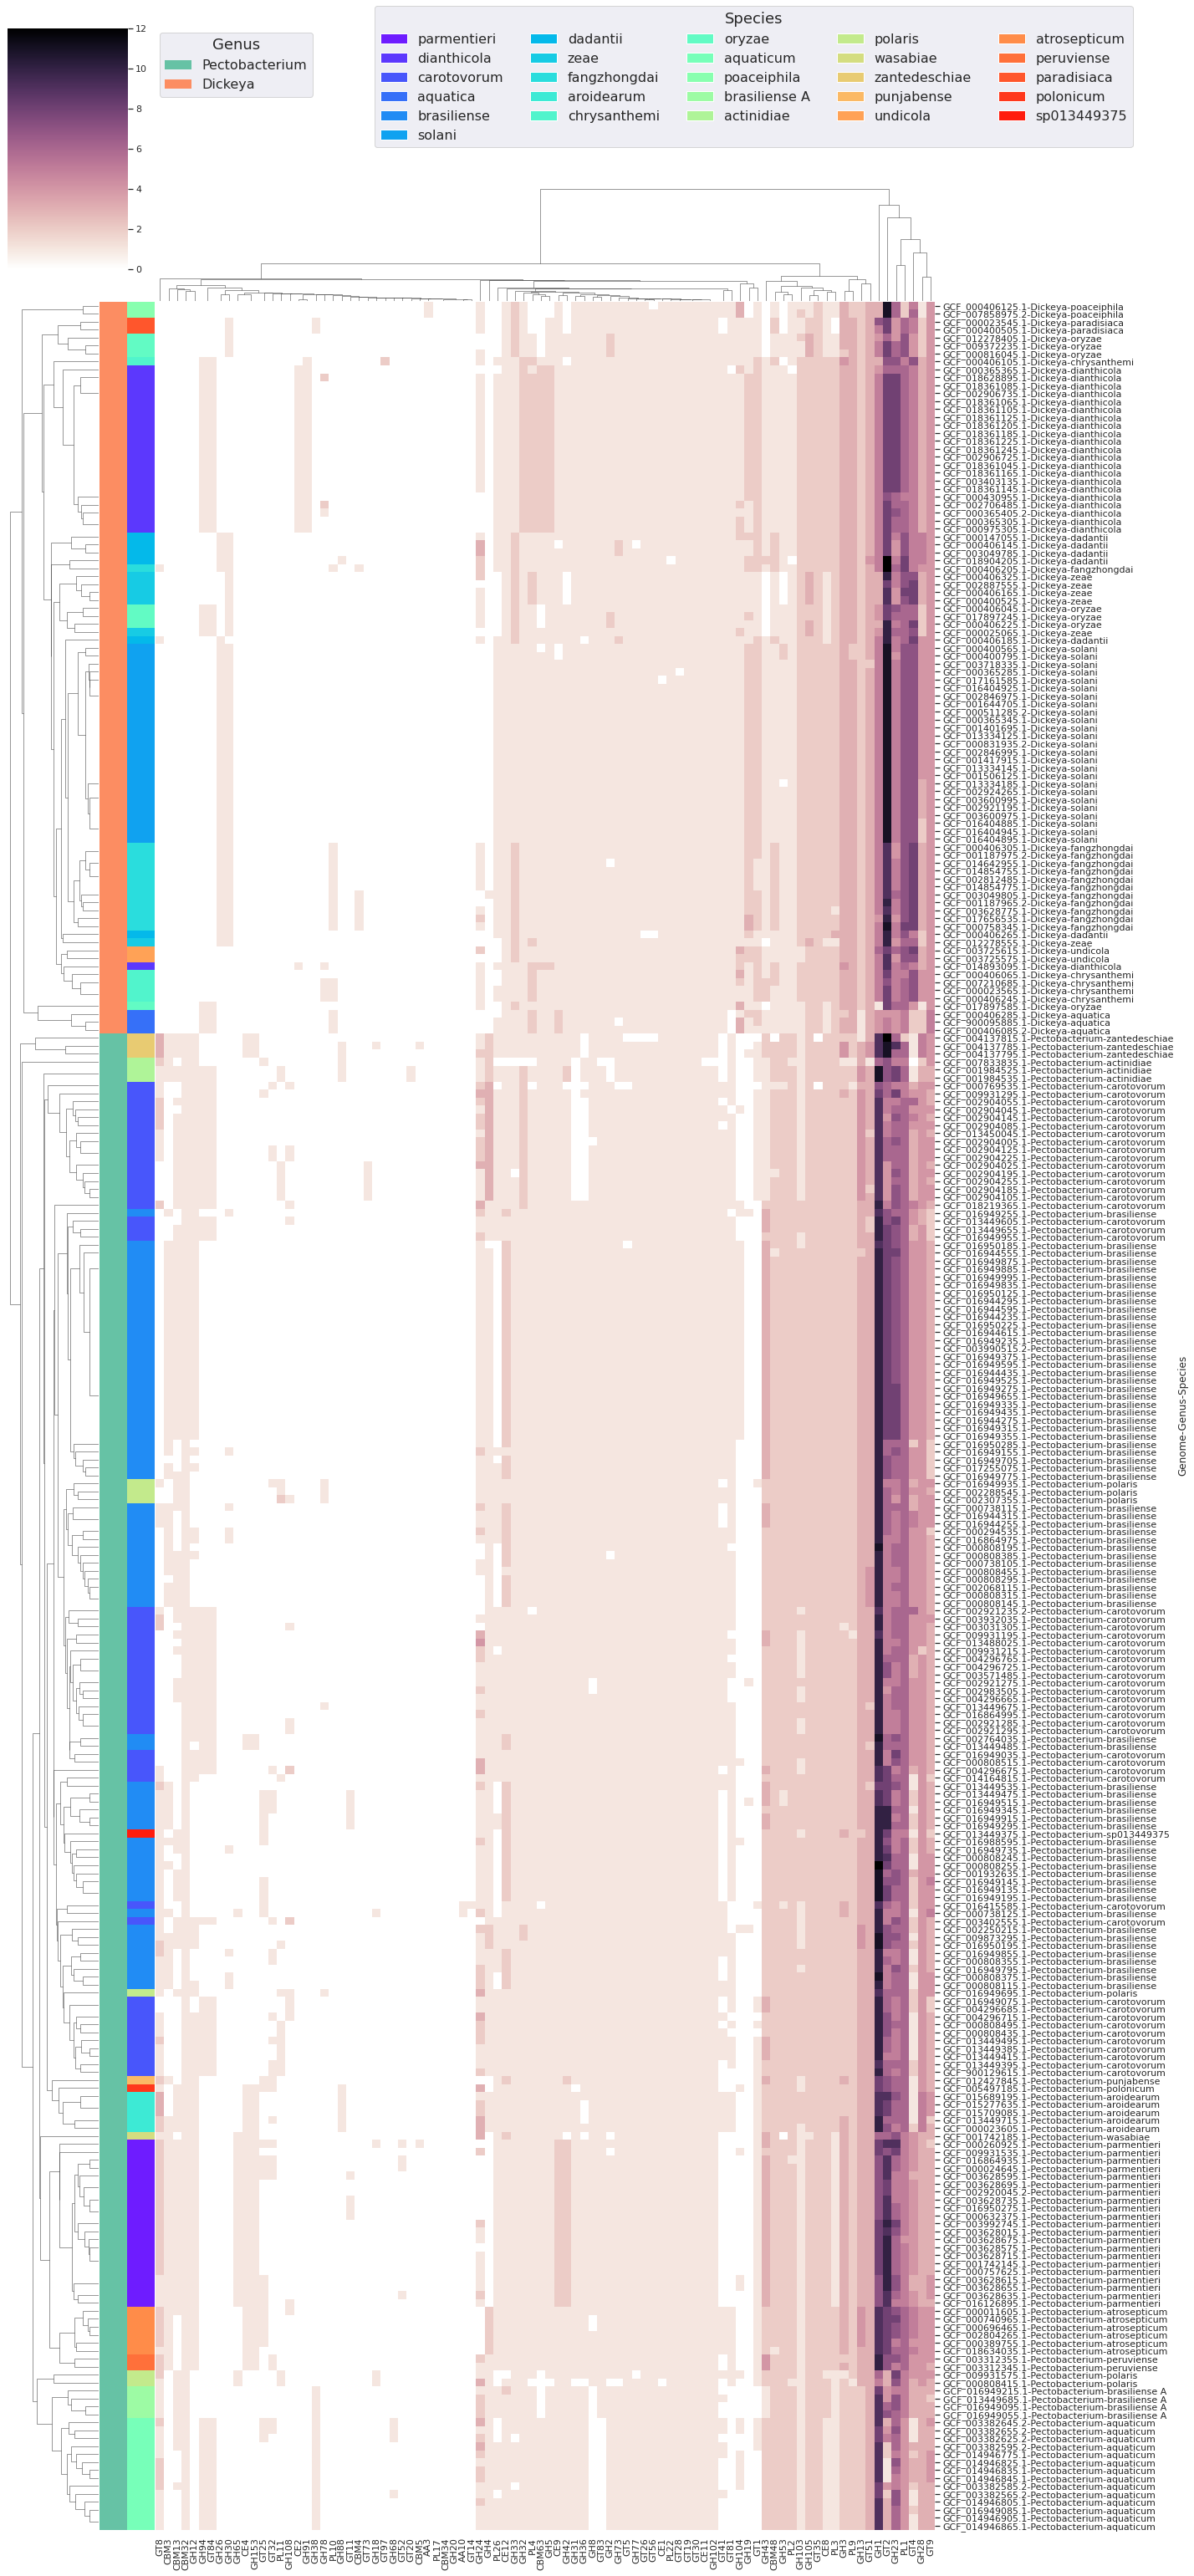

In [27]:
# make a figure the optimal size to fit in a paper
build_family_clustermap_multi_legend(
    df=fam_freq_df_ggs,
    row_colours=[fam_freq_genus_row_colours,fam_freq_species_row_colours],
    luts=[fam_g_lut, fam_s_lut],
    legend_titles=['Genus', 'Species'],
    bbox_to_anchors=[(0.2,1.045), (0.63,1.04)],
    legend_cols=[1,5],
    fig_size=(20,40),
    file_path="../results/pecto_dic/cazy_families/paper_pd_genus_species_fam_freq_clustermap.png",
    file_format='png',
    font_scale=1,
    dendrogram_ratio=(0.1,0.05),
    title_fontsize=18,
    legend_fontsize=16,
    cbar_pos=(0.01, 0.96, 0.1, 0.1),  #left, bottom, width, height
)

/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


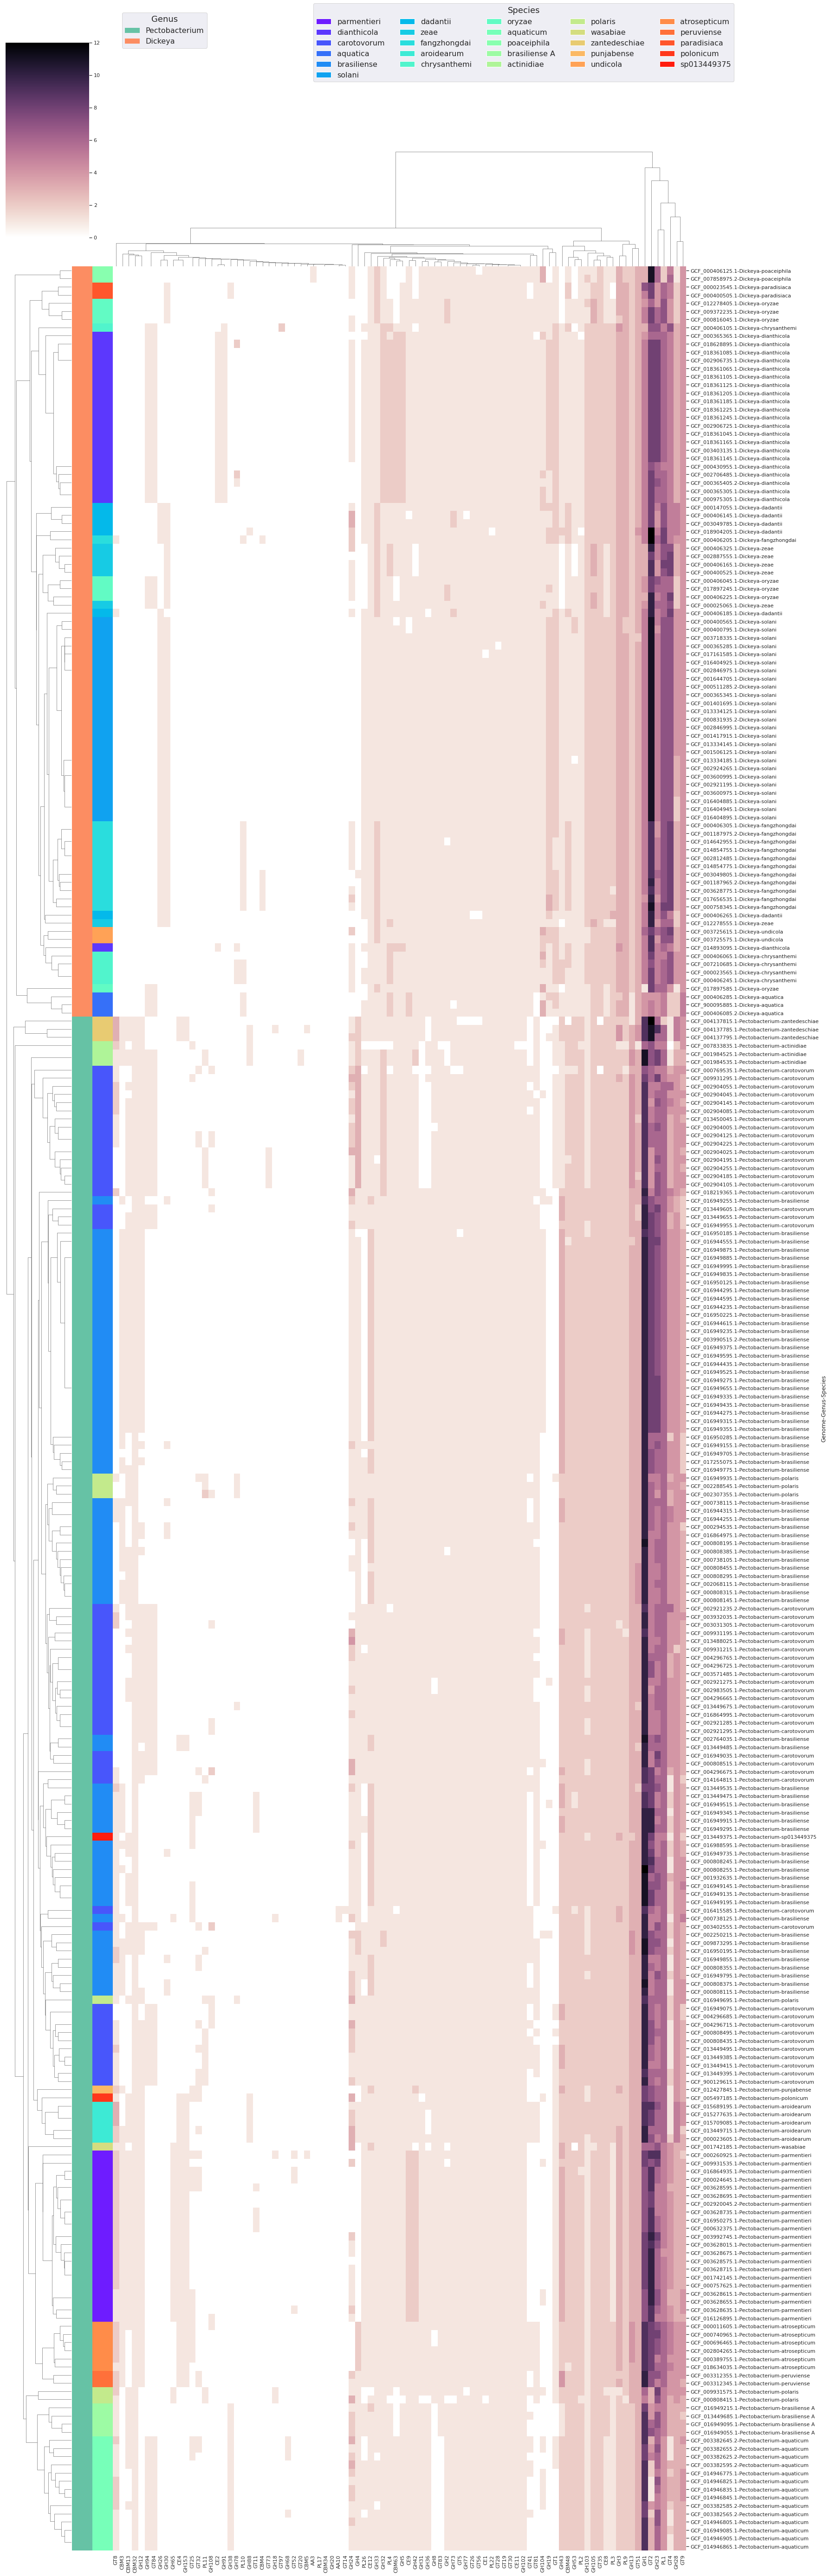

In [28]:
# make a figure the optimal size to fit in a paper
build_family_clustermap_multi_legend(
    df=fam_freq_df_ggs,
    row_colours=[fam_freq_genus_row_colours,fam_freq_species_row_colours],
    luts=[fam_g_lut, fam_s_lut],
    legend_titles=['Genus', 'Species'],
    bbox_to_anchors=[(0.2,1.045), (0.63,1.04)],
    legend_cols=[1,5],
    fig_size=(25,73),
    file_path="../results/pecto_dic/cazy_families/pd_genus_species_fam_freq_clustermap.svg",
    file_format='svg',
    font_scale=1,
    dendrogram_ratio=(0.1,0.05),
    title_fontsize=18,
    legend_fontsize=16,
    cbar_pos=(0.01, 0.96, 0.1, 0.08),  #left, bottom, width, height
)

### Genus specific CAZy families

Identify CAZy families that are only present in one group, e.g. one Genus, using the function `get_group_specific_fams` from `cazomevolve`.

Specifically, `get_group_specific_fams` returns two `dicts`:
1. Group specific families: `{group: {only unique fams}}`
2. All families per group: `{group: {all fams}}`

In [29]:
all_families = list(fam_freq_df_pd.columns)[3:]
# dict {group: {only unique fams}} and dict {group: {all fams}}
unique_grp_fams, group_fams = get_group_specific_fams(fam_freq_df_pd, 'Genus', all_families)
unique_grp_fams

Identifying Genus specific fams: 100%|██████████| 2/2 [00:00<00:00, 15679.64it/s]


{'Pectobacterium': {'AA10',
  'CBM13',
  'CBM3',
  'CBM32',
  'CBM5',
  'CE4',
  'GH108',
  'GH12',
  'GH153',
  'GH18',
  'GH65',
  'GH68',
  'GT11',
  'GT14',
  'GT20',
  'GT25',
  'GT32',
  'GT52',
  'GT73',
  'PL11'},
 'Dickeya': {'AA3', 'CBM4', 'CE2', 'GH26', 'GH91', 'GT97', 'PL10'}}

<a id="core-cazome"> </a>
## 4. The Core CAZome

Identify CAzy families that are present in every genome in the dataset using `identify_core_cazome()`, which takes the dataframe of CAZy family frequencies (with only CAZy families included in the columns, i.e no taxonomy columns). These families form the 'core CAZome'.

In [30]:
core_cazome = identify_core_cazome(fam_freq_df_ggs)

core_cazome = list(core_cazome)
core_cazome.sort()

print("The core CAZy families are:")
for fam in core_cazome:
    print('-', fam)

Identifying core CAZome: 100%|██████████| 90/90 [00:00<00:00, 12558.63it/s]

The core CAZy families are:
- CE8
- GH1
- GH103
- GH105
- GH13
- GH23
- GH28
- GH3
- GT19
- GT2
- GT30
- GT51
- GT9
- PL1
- PL9


Build a one-dimensional box plot, using `plot_fam_boxplot()`, which plots the frequency of each CAZy family in the core CAZome across the dataset.

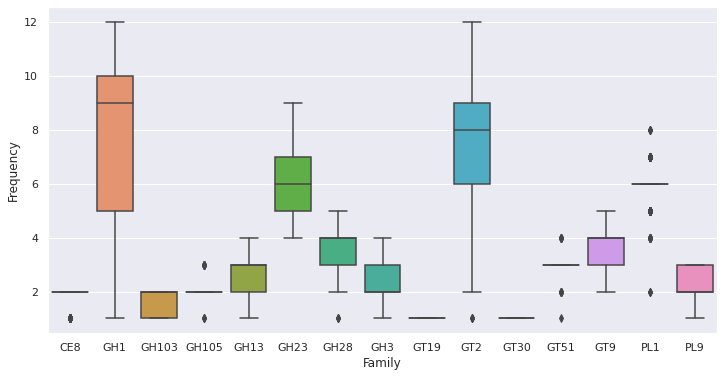

In [31]:
# filter the famil freq df to include only those families in the core CAZome
core_cazome_df = fam_freq_df_ggs[core_cazome]
plot_fam_boxplot(core_cazome_df, font_scale=0.8, fig_size=(12,6))

The boxplot shows the frequency of each CAZy family across all genomes in the dataframe. We can also break down this data by genus, and build a dataframe of Family, Genus (or tax rank of choice), genome, and frequency.

This dataframe can then be used to build a second dataframe of:
* Family
* Tax rank
* Mean frequency
* SD frequency
Which can be presented as is in a report, or imported into [RawGraphs](https://app.rawgraphs.io/) to build a matrix plot (aka a proporitonal area plot).

In [32]:
core_cazome_df_genus = copy(core_cazome_df)  # to ensure core_cazome_df is not altereted
core_cazome_df_genus = add_tax_column_from_row_index(core_cazome_df_genus, 'Genus', 1)
core_cazome_df_genus.head(1)

CE8  GH1  GH103  GH105  GH13   
Genome          Genus          Species                                     
GCF_016864935.1 Pectobacterium parmentieri    2    7      1      2     3  \

                                            GH23  GH28  GH3  GT19  GT2  GT30   
Genome          Genus          Species                                         
GCF_016864935.1 Pectobacterium parmentieri     6     3    3     1    9     1  \

                                            GT51  GT9  PL1  PL9   
Genome          Genus          Species                            
GCF_016864935.1 Pectobacterium parmentieri     3    3    5    2  \

                                                     Genus  
Genome          Genus          Species                      
GCF_016864935.1 Pectobacterium parmentieri  Pectobacterium

In [33]:
help(build_fam_mean_freq_df)

Help on function build_fam_mean_freq_df in module cazomevolve.cazome.explore.cazy_families:

build_fam_mean_freq_df(df, grp, round_by=None)
    Build two dataframes of fam frequencies from a wide fam freq df
    
    DF 1: Family, tax rank (i.e. group), genome, freq
    DF 2: Family, tax rank (i.e. group), mean freq, sd freq
    
    :param df: pandas df, each row is a genome and each column a CAZy family
        and one column with tax rank listed (e.g. a 'Genus' column)
        and index includes the genomic accession
    :param grp: str, name of tax rank to group data by, and matches a name of one 
        of the columns in the dataframe (e.g. a 'Genus' column)
    :param round_by: int, number of decimal points to round by. If None, does not round
    
    Return two dataframes



In [34]:
core_cazome_fggf_df, core_cazome_mean_freq_df = build_fam_mean_freq_df(
    core_cazome_df_genus,
    'Genus',
    round_by=2,
)
make_output_directory(Path("../results/pecto_dic/core_cazome/"), nodelete=True, force=True)
core_cazome_mean_freq_df.to_csv("../results/pecto_dic/core_cazome/core_cazome_freqs.csv")

core_cazome_mean_freq_df

Building [Fam, grp, mean freq, sd freq] df: 100%|██████████| 2/2 [00:00<00:00, 52.01it/s]
Output directory ../results/pecto_dic/core_cazome exists, nodelete is True. Adding output to output directory.


Family           Genus  MeanFreq  SdFreq
0     CE8  Pectobacterium      1.92    0.27
1     GH1  Pectobacterium      9.32    1.13
2   GH103  Pectobacterium      1.48    0.50
3   GH105  Pectobacterium      1.99    0.07
4    GH13  Pectobacterium      3.01    0.51
5    GH23  Pectobacterium      6.20    0.99
6    GH28  Pectobacterium      3.79    0.52
7     GH3  Pectobacterium      2.20    0.46
8    GT19  Pectobacterium      1.00    0.00
9     GT2  Pectobacterium      6.57    2.05
10   GT30  Pectobacterium      1.00    0.00
11   GT51  Pectobacterium      2.99    0.31
12    GT9  Pectobacterium      3.18    0.59
13    PL1  Pectobacterium      5.65    0.67
14    PL9  Pectobacterium      1.98    0.14
15    CE8         Dickeya      1.77    0.42
16    GH1         Dickeya      4.72    0.77
17  GH103         Dickeya      1.88    0.32
18  GH105         Dickeya      2.09    0.35
19   GH13         Dickeya      1.97    0.18
20   GH23         Dickeya      5.54    1.28
21   GH28         Dickeya      3.09    0.86
22    GH3         Dickeya      3.00    0.21
23   GT19         Dickeya      1.00    0.00
24    GT2         Dickeya      9.12    1.67
25   GT30         Dickeya      1.00    0.00
26   GT51         Dickeya      3.00    0.15
27    GT9         Dickeya      4.03    0.18
28    PL1         Dickeya      6.45    0.95
29    PL9         Dickeya      2.96    0.20

### Genus specific core CAZomes

The identification of the core CAZome was completed for all _Pectobacterium_ and _Dickeya_ genomes.

The datafame of genomes can be filtered to contain only genomes for one genus (or a tax rank of choice). Afterwhich, the core CAZome for a specfic genus (or tax rank of choice).

In [35]:
# add a tax rank (e.g. genus) column so that the genomes can be grouped by their tax rank
fam_freq_df_ggs_genus = copy(fam_freq_df_ggs)  # to ensure core_cazome_df is not altereted
fam_freq_df_ggs_genus = add_tax_column_from_row_index(fam_freq_df_ggs_genus, 'Genus', 1)
fam_freq_df_ggs_genus.head(1)

AA10  AA3  CBM13  CBM3  CBM32   
Genome          Genus          Species                                      
GCF_016864935.1 Pectobacterium parmentieri     0    0      1     1      1  \

                                            CBM34  CBM4  CBM48  CBM5  CBM63   
Genome          Genus          Species                                        
GCF_016864935.1 Pectobacterium parmentieri      0     0      2     0      1  \

                                            ...  PL10  PL11  PL17  PL2  PL22   
Genome          Genus          Species      ...                                
GCF_016864935.1 Pectobacterium parmentieri  ...     0     0     0    1     1  \

                                            PL26  PL3  PL4  PL9   
Genome          Genus          Species                            
GCF_016864935.1 Pectobacterium parmentieri     1    1    1    2  \

                                                     Genus  
Genome          Genus          Species                      
GCF_016864935.1 Pectobacterium parmentieri  Pectobacterium  

[1 rows x 91 columns]

<a id="pecto-core-cazome"> </a>
### _Pectobacterium_ Core CAZome

In [36]:
# filter for only pectobacterium genomes
pecto_freq_df_ggs_genus = fam_freq_df_ggs_genus[fam_freq_df_ggs_genus['Genus'] == 'Pectobacterium']
print(f"Analysing {len(pecto_freq_df_ggs_genus)} Pectobacterium genomes")

# Identify the core CAZome
pecto_core_cazome = identify_core_cazome(pecto_freq_df_ggs_genus)
print("The core CAZy families in Pectobacterium are:")
pecto_core_cazome = list(pecto_core_cazome)
pecto_core_cazome.sort()
for fam in pecto_core_cazome:
    print('-', fam)

Analysing 188 Pectobacterium genomes


Identifying core CAZome: 100%|██████████| 91/91 [00:00<00:00, 12573.10it/s]

The core CAZy families in Pectobacterium are:
- CBM32
- CE8
- CE9
- GH1
- GH103
- GH105
- GH13
- GH23
- GH28
- GH3
- GH43
- GT19
- GT2
- GT28
- GT30
- GT51
- GT9
- Genus
- PL1
- PL2
- PL22
- PL3
- PL9


<a id="dic-core-cazome"> </a>
### _Dickeya_ Core CAZome

In [37]:
# filter for only dickeya genomes
dic_freq_df_ggs_genus = fam_freq_df_ggs_genus[fam_freq_df_ggs_genus['Genus'] == 'Dickeya']
print(f"Analysing {len(dic_freq_df_ggs_genus)} Dickeya genomes")

# Identify the core CAZome
dic_core_cazome = identify_core_cazome(dic_freq_df_ggs_genus)
print("The core CAZy families in Dickeya are:")
dic_core_cazome = list(dic_core_cazome)
dic_core_cazome.sort()
for fam in dic_core_cazome:
    print('-', fam)

Analysing 92 Dickeya genomes


Identifying core CAZome: 100%|██████████| 91/91 [00:00<00:00, 14271.67it/s]

The core CAZy families in Dickeya are:
- CBM48
- CE11
- CE12
- CE8
- GH1
- GH102
- GH103
- GH104
- GH105
- GH13
- GH23
- GH28
- GH3
- GH31
- GH32
- GH33
- GH8
- GT1
- GT19
- GT2
- GT30
- GT35
- GT4
- GT5
- GT51
- GT83
- GT9
- Genus
- PL1
- PL9


### Combine the mean core CAZy family frequencies

For the genus specific families, calculate the mean frequency across the genomes using `build_fam_mean_freq_df()`, and append the resulting data to the `core_cazome_mean_freq_df` dataframe.

In [38]:
core_cazome_mean_freq_df.head(1)

Family           Genus  MeanFreq  SdFreq
0    CE8  Pectobacterium      1.92    0.27

In [39]:
dic_freq_df_ggs_genus.head(1)
dic_only_core_fams = [fam for fam in dic_core_cazome if fam not in core_cazome]
dic_freq_df_ggs_genus_core_cazome = dic_freq_df_ggs_genus[dic_only_core_fams]

d_core_cazome_fggf_df, d_core_cazome_mean_freq_df = build_fam_mean_freq_df(
    dic_freq_df_ggs_genus_core_cazome,
    'Genus',
    round_by=2,
)

pecto_freq_df_ggs_genus.head(1)
pecto_only_core_fams = [fam for fam in pecto_core_cazome if fam not in core_cazome]
pecto_freq_df_ggs_genus_core_cazome = pecto_freq_df_ggs_genus[pecto_only_core_fams]

p_core_cazome_fggf_df, p_core_cazome_mean_freq_df = build_fam_mean_freq_df(
    pecto_freq_df_ggs_genus_core_cazome,
    'Genus',
    round_by=2,
)

pd_core_cazome_mean_freq_df = copy(core_cazome_mean_freq_df)
pd_core_cazome_mean_freq_df = pd.concat(
    [pd_core_cazome_mean_freq_df, d_core_cazome_mean_freq_df],
    ignore_index=True,
)
pd_core_cazome_mean_freq_df = pd.concat(
    [pd_core_cazome_mean_freq_df, p_core_cazome_mean_freq_df],
    ignore_index=True,
)

pd_core_cazome_mean_freq_df.to_csv("../results/pecto_dic/core_cazome/pd_all_core_cazome_freqs.csv")
pd_core_cazome_mean_freq_df

Building [Fam, grp, mean freq, sd freq] df: 100%|██████████| 1/1 [00:00<00:00, 115.09it/s]


Family           Genus  MeanFreq  SdFreq
0     CE8  Pectobacterium      1.92    0.27
1     GH1  Pectobacterium      9.32    1.13
2   GH103  Pectobacterium      1.48    0.50
3   GH105  Pectobacterium      1.99    0.07
4    GH13  Pectobacterium      3.01    0.51
5    GH23  Pectobacterium      6.20    0.99
6    GH28  Pectobacterium      3.79    0.52
7     GH3  Pectobacterium      2.20    0.46
8    GT19  Pectobacterium      1.00    0.00
9     GT2  Pectobacterium      6.57    2.05
10   GT30  Pectobacterium      1.00    0.00
11   GT51  Pectobacterium      2.99    0.31
12    GT9  Pectobacterium      3.18    0.59
13    PL1  Pectobacterium      5.65    0.67
14    PL9  Pectobacterium      1.98    0.14
15    CE8         Dickeya      1.77    0.42
16    GH1         Dickeya      4.72    0.77
17  GH103         Dickeya      1.88    0.32
18  GH105         Dickeya      2.09    0.35
19   GH13         Dickeya      1.97    0.18
20   GH23         Dickeya      5.54    1.28
21   GH28         Dickeya      3.09    0.86
22    GH3         Dickeya      3.00    0.21
23   GT19         Dickeya      1.00    0.00
24    GT2         Dickeya      9.12    1.67
25   GT30         Dickeya      1.00    0.00
26   GT51         Dickeya      3.00    0.15
27    GT9         Dickeya      4.03    0.18
28    PL1         Dickeya      6.45    0.95
29    PL9         Dickeya      2.96    0.20
30  CBM48         Dickeya      1.25    0.43
31   CE11         Dickeya      1.00    0.00
32   CE12         Dickeya      1.00    0.00
33  GH102         Dickeya      1.00    0.00
34  GH104         Dickeya      1.25    0.58
35   GH31         Dickeya      1.00    0.00
36   GH32         Dickeya      1.24    0.43
37   GH33         Dickeya      1.40    0.49
38    GH8         Dickeya      1.00    0.00
39    GT1         Dickeya      1.75    0.43
40   GT35         Dickeya      2.00    0.00
41    GT4         Dickeya      6.17    1.45
42    GT5         Dickeya      1.00    0.00
43   GT83         Dickeya      1.00    0.00
44  CBM32  Pectobacterium      1.00    0.00
45    CE9  Pectobacterium      1.11    0.31
46   GH43  Pectobacterium      2.28    0.68
47   GT28  Pectobacterium      1.00    0.00
48    PL2  Pectobacterium      1.98    0.13
49   PL22  Pectobacterium      1.00    0.00
50    PL3  Pectobacterium      1.78    0.42

<a id="co-occurring"> </a>
## 5. Families that always occur together

Identify CAZy families that are always present in the genome together - this approach does not tolerate one CAZy family ever appearing without the other family in the same genome.

In [40]:
# reminder of the structure of the df
fam_freq_df.head(1)

Genome           Genus      Species  AA10  AA3  CBM13  CBM3   
0  GCF_016864935.1  Pectobacterium  parmentieri     0    0      1     1  \

   CBM32  CBM34  CBM4  ...  PL1  PL10  PL11  PL17  PL2  PL22  PL26  PL3  PL4   
0      1      0     0  ...    5     0     0     0    1     1     1    1    1  \

   PL9  
0    2  

[1 rows x 93 columns]

In [41]:
# reminder of the structure of the df
fam_freq_df_pd.head(1)

Genome           Genus      Species  AA10  AA3  CBM13  CBM3   
0  GCF_016864935.1  Pectobacterium  parmentieri     0    0      1     1  \

   CBM32  CBM34  CBM4  ...  PL1  PL10  PL11  PL17  PL2  PL22  PL26  PL3  PL4   
0      1      0     0  ...    5     0     0     0    1     1     1    1    1  \

   PL9  
0    2  

[1 rows x 93 columns]

**Using a correlation matrix:**

CAZy families that always appear together can be identified by generating a correlation matrix using the Python package `pandas`, CAZy families that are always present together will have a correlation matrix of 1. 

This can be done using the `identify_cooccurring_fams_corrM()` function. CAZy families that are always present in the genome (i.e. the core CAZome), or are absent from all genomes will be calulcated to have a correlation score of `nan`. In order to plot the correlation matrix, the `fill_value` key word for `identify_cooccurring_fams_corrM()` can be used to replace all `nan` values with an interger.

`identify_cooccurring_fams_corrM()` returns a correlation matrix and ...

In [42]:
all_families = list(fam_freq_df_pd.columns[3:])

make_output_directory(Path("../results/pecto_dic/cooccurring_families/"), force=True, nodelete=True)
cooccurring_families, fam_corr_M_filled = identify_cooccurring_fams_corrM(
    fam_freq_df_pd,
    all_families,
    core_cazome=[],
    corrM_path="../results/pecto_dic/cooccurring_families/fam_corr_M_filled.csv",
    fill_value=2,
)

Built output directory: ../results/pecto_dic/cooccurring_families
Identifying always co-occurring families: 100%|██████████| 90/90 [00:00<00:00, 2375.48it/s]


In [43]:
cooccurring_families

{('CE11', 'GH102', 'GH32', 'GT4'), ('CE4', 'GH153'), ('GH94', 'GT84')}

Generate a clustermap of the correlation matrix.

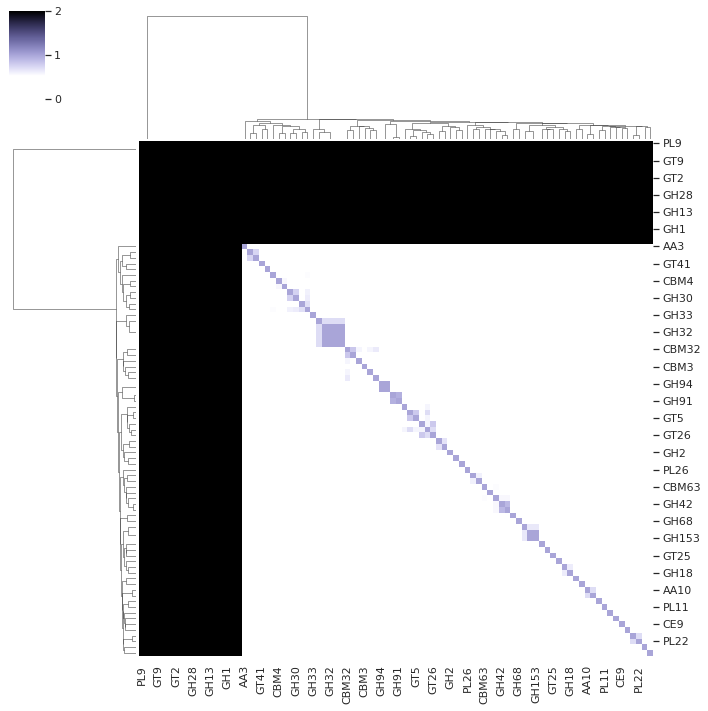

In [44]:
sns.clustermap(
    fam_corr_M_filled,
    cmap=sns.cubehelix_palette(rot=0, dark=2, light=0, reverse=True, as_cmap=True),
)

**An iterative approach to identify co-occurring families:**

Iterate through the dataframe of CAZy family frequencies in _Pectobacterium_ and _Dickeya_ (`fam_freq_df_pd`) and identify the groups of always co-occurring CAZy families (i.e. those families that are always present together) and count the number of genomes in which the families are present together.

This is done using the `cazomevolve` function `calc_cooccuring_fam_freqs`, which returns a dictionary of groups of co-occurring CAZy families. The function takes as input:
1. The dataframe of CAZy family frequencies (it can include taxonomy information in columns)
2. A list of the CAZy families to analyse
3. (Optional) whether to include or exclude the core CAZome from the list of always co-occurring CAZy families.

In [45]:
cooccurring_fams_dict = calc_cooccuring_fam_freqs(
    fam_freq_df_pd,
    list(fam_freq_df_pd.columns[3:]),
    exclude_core_cazome=False,
)
cooccurring_fams_dict

Combining pairs of co-occurring families: 100%|██████████| 113/113 [00:00<00:00, 382531.36it/s]


{0: {'fams': {'CE11', 'GH102', 'GH32', 'GT4'}, 'freqs': {279}},
 1: {'fams': {'CE4', 'GH153'}, 'freqs': {41}},
 2: {'fams': {'CE8',
   'GH1',
   'GH103',
   'GH105',
   'GH13',
   'GH23',
   'GH28',
   'GH3',
   'GT19',
   'GT2',
   'GT30',
   'GT51',
   'GT9',
   'PL1',
   'PL9'},
  'freqs': {280}},
 3: {'fams': {'GH94', 'GT84'}, 'freqs': {97}}}

Identify groups of co-occurring families in only _Pectobacterium_ or _Dickeya_ genomes.

In [46]:
# Pectobacterium
pecto_fam_freq_df = fam_freq_df_pd[fam_freq_df_pd['Genus'] == 'Pectobacterium']
pecto_cooccurring_fams_dict = calc_cooccuring_fam_freqs(pecto_fam_freq_df, list(pecto_fam_freq_df.columns[3:]), exclude_core_cazome=False)
pecto_cooccurring_fams_dict

Combining pairs of co-occurring families: 100%|██████████| 243/243 [00:00<00:00, 463912.55it/s]


{0: {'fams': {'CBM32',
   'CE8',
   'CE9',
   'GH1',
   'GH103',
   'GH105',
   'GH13',
   'GH23',
   'GH28',
   'GH3',
   'GH43',
   'GT19',
   'GT2',
   'GT28',
   'GT30',
   'GT51',
   'GT9',
   'PL1',
   'PL2',
   'PL22',
   'PL3',
   'PL9'},
  'freqs': {188}},
 1: {'fams': {'CBM48', 'GT26', 'GT56'}, 'freqs': {187}},
 2: {'fams': {'CE1', 'GH5'}, 'freqs': {187}},
 3: {'fams': {'CE11', 'GH102', 'GH32', 'GT4'}, 'freqs': {187}},
 4: {'fams': {'CE4', 'GH153'}, 'freqs': {41}},
 5: {'fams': {'GH94', 'GT84'}, 'freqs': {67}}}

In [47]:
# Dickeya
dic_fam_freq_df = fam_freq_df_pd[fam_freq_df_pd['Genus'] == 'Dickeya']
dic_cooccurring_fams_dict = calc_cooccuring_fam_freqs(dic_fam_freq_df, list(dic_fam_freq_df.columns[3:]), exclude_core_cazome=False)
dic_cooccurring_fams_dict

Combining pairs of co-occurring families: 100%|██████████| 409/409 [00:00<00:00, 743916.02it/s]


{0: {'fams': {'CBM48',
   'CE11',
   'CE12',
   'CE8',
   'GH1',
   'GH102',
   'GH103',
   'GH104',
   'GH105',
   'GH13',
   'GH23',
   'GH28',
   'GH3',
   'GH31',
   'GH32',
   'GH33',
   'GH8',
   'GT1',
   'GT19',
   'GT2',
   'GT30',
   'GT35',
   'GT4',
   'GT5',
   'GT51',
   'GT83',
   'GT9',
   'PL1',
   'PL9'},
  'freqs': {92}},
 1: {'fams': {'GH19', 'GH5'}, 'freqs': {90}},
 2: {'fams': {'GH94', 'GT84'}, 'freqs': {30}},
 3: {'fams': {'GT41', 'PL3'}, 'freqs': {90}}}

### Build an upset plot of co-occurring CAZy families

Build an upsetplot (using the Python package `upsetplot`) to visulise the groups of always co-occurring CAZy families, additionally it will plot the number of genomes in which each group of co-occurring CAZy families were present.

First compile the data/membership for the upset plot by:
1. Creating an empty list to store the upset plot data
2. Adding to the empty list the data contained in each dictionary of co-occurring CAZy families by using the `add_to_upsetplot_membership()` function

In [48]:
upsetplot_membership = []
upsetplot_membership = add_to_upsetplot_membership(upsetplot_membership, cooccurring_fams_dict)
upsetplot_membership = add_to_upsetplot_membership(upsetplot_membership, pecto_cooccurring_fams_dict)
upsetplot_membership = add_to_upsetplot_membership(upsetplot_membership, dic_cooccurring_fams_dict)
len(upsetplot_membership)

1856

Build the upset plot.

In [49]:
help(build_upsetplot)

Help on function build_upsetplot in module cazomevolve.cazome.explore.cooccurring_families:

build_upsetplot(upsetplot_membership, file_path=None, file_format='svg', sort_by='degree', sort_categories_by='cardinality')
    Use the upsetplot package to build an upsetplot of co-occurring families
    
    :param upsetplot_membership: list of lists, one nested list per instance of co-occurring families group
    :param file_path, str/Path, path to write out figure. If none, file is not written out
    :param file_format: str, format to write out file, e.g. svg or png, default, svg
    :param sort_by: str, method to sort subsets 
        From Upsetplot:
            sort_by : {'cardinality', 'degree', '-cardinality', '-degree',
                    'input', '-input'}
                If 'cardinality', subset are listed from largest to smallest.
                If 'degree', they are listed in order of the number of categories
                intersected. If 'input', the order they appear in the

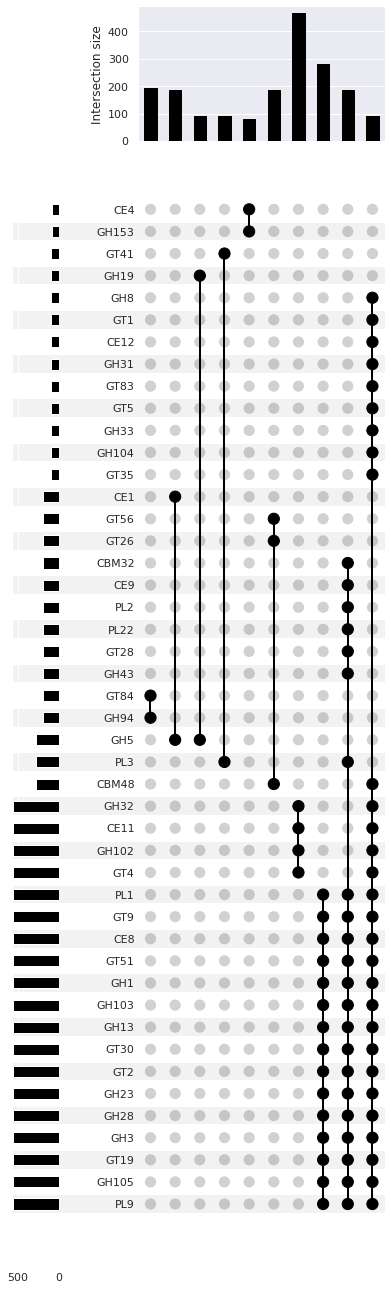

In [50]:
pecto_dic_upsetplot = build_upsetplot(
    upsetplot_membership,
    file_path='../results/pecto_dic/cooccurring_families/pd_cooccurring_fams.svg',
)

**Break down the incidences per genus:**

The upset plot generates a bar chart showing the number of genomes that each group of co-occuring CAZy families appeared in. However, this plots the total number across each of the groups (i.e. _Pectobacterium_, _Dickeya_, and both).

To break down the indidence (i.e. the number of genomes that each group of co-occurring CAZy families were present in) per group, a dataframe listing each group of co-occurring CAZy families, the group (i.e. genus), and the respective frequency must be generated. This dataframe can then be used to generate a proportional area plot (or matrix plot), breaking down the incidence per group (i.e. genus).

The groups of co-occurring CAZy families must be listed in the same order as they are presented in the upset plot.

In [51]:
upset_plot_groups = get_upsetplot_grps(upsetplot_membership)

100%|██████████| 10/10 [00:00<00:00, 57.27it/s]


Compiling the data of the incidence of each grp of co-occurring CAZy families per group of interest (e.g. per genus), into a single dataframe.

Create an empty list to store all data for the dataframe, then use `add_upsetplot_grp_freqs` to add data of the incidence per group of co-occurring CAZy families to the list. `build_upsetplot_matrix` is then used to build the dataframe.

In [52]:
help(add_upsetplot_grp_freqs)

Help on function add_upsetplot_grp_freqs in module cazomevolve.cazome.explore.cooccurring_families:

add_upsetplot_grp_freqs(upset_plt_groups, cooccurring_grp_freq_data, cooccurring_fam_dict, grp, grp_sep=False, grp_order=None, include_none=False)
    Add data on the incidence of co-occurring grps of CAZy families from the
    cooccurring_fam_dict to cooccurring_grp_freq_data
    
    :param upset_plt_groups: list of lists, one nested list per grp of co-occurring CAZy families
        grps listed in same order as present in the upsetplot
    :param cooccurring_grp_freq_data: list of lists, one nested list per 
        pair of 'grp' and grp of co-occurring CAZy families
    :param cooccurring_fam_dict: dict, {grp_num: {'fams': {families}, 'freqs': {freqs/incidences}}}
    :param grp: str, name of grp to be added to cooccurring_grp_freq_data, e.g. the name of the genus
    :param grp_sep: bool, does the cooccurring_fam_dict contain data separated into grps, e.g. by genus
        {grp(e.g

In [53]:
cooccurring_grp_freq_data = []  # empty list to store data for the df

cooccurring_grp_freq_data = add_upsetplot_grp_freqs(
    upset_plot_groups,
    cooccurring_grp_freq_data,
    cooccurring_fams_dict,
    'Both',
)
cooccurring_grp_freq_data= add_upsetplot_grp_freqs(
    upset_plot_groups,
    cooccurring_grp_freq_data,
    pecto_cooccurring_fams_dict,
    'Pectobacterium',
)
cooccurring_grp_freq_data= add_upsetplot_grp_freqs(
    upset_plot_groups,
    cooccurring_grp_freq_data,
    dic_cooccurring_fams_dict,
    'Dickeya',
)

Compiling co-occurring families incidence data: 100%|██████████| 10/10 [00:00<00:00, 87746.95it/s]


Build a single dataframe of co-occurring families, freq and group (e.g. genus).

But also list the information for each group in the same order the groups of CAZy families are listed in the upset plot. This allows a proportional area plot to be generated (for example, by using [RawGraphs](https://app.rawgraphs.io/)), which can then be combined with the upset plot (for example, using [inkscape](https://inkscape.org/)).

In [54]:
help(build_upsetplot_matrix)

Help on function build_upsetplot_matrix in module cazomevolve.cazome.explore.cooccurring_families:

build_upsetplot_matrix(cooccurring_grp_freq_data, grp, file_path=None)
    Build matrix of grp of CAZy families, grp of interest name (e.g. genus) and incidence 
    (i.e. the number of genomes that the grp of CAZy families appeared in)
    
    :param cooccurring_grp_freq_data: list of lists, one nested list per row in the df
    :param grp: str, name of grouping, i.e. the method used to group the genomes,
        .e.g. 'Genus', or 'Species'
    :param file_path: str/Path, path to write out CSV file. If none, the file is not 
        written to file
        
    Return df



In [55]:
# build the dataframe
cooccurring_fams_freq_df = build_upsetplot_matrix(
    cooccurring_grp_freq_data,
    'Genus',
    file_path='../results/pecto_dic/cooccurring_families/cooccurring_fams_freqs.csv',
)
cooccurring_fams_freq_df

Families           Genus   
0                                           GH94+GT84            Both  \
1                                           GH153+CE4            Both   
2                                 GT4+GH102+CE11+GH32            Both   
3   PL9+GH105+GT19+GH3+GH28+GH23+GT2+GT30+GH13+GH1...            Both   
4                                           GH94+GT84  Pectobacterium   
5                                             GH5+CE1  Pectobacterium   
6                                           GH153+CE4  Pectobacterium   
7                                     CBM48+GT26+GT56  Pectobacterium   
8                                 GT4+GH102+CE11+GH32  Pectobacterium   
9   PL9+GH105+GT19+GH3+GH28+GH23+GT2+GT30+GH13+GH1...  Pectobacterium   
10                                          GH94+GT84         Dickeya   
11                                           GH5+GH19         Dickeya   
12                                           PL3+GT41         Dickeya   
13  PL9+GH105+GT19+GH3+GH28+GH23+GT2+GT30+GH13+GH1...         Dickeya   

    Incidence  
0          97  
1          41  
2         279  
3         280  
4          67  
5         187  
6          41  
7         187  
8         187  
9         188  
10         30  
11         90  
12         90  
13         92

<a id="pca"></a>
## 6. Principal Component Analysis (PCA)

Use principal component analysis to identify individual and groups of CAZy families that are strongly associated with divergence between the composition of _Pectobacterium_ and _Dickeya_ CAZomes in terms of CAZy family frequencies. 

Use the `cazomevolve` function `perform_pca()` to perform a PCA on a dataframe where each row is a genome, and each column the frequency of a unique CAZy family - the columns in the dataframe must only contain numerical data (i.e. no taxonomic data).

In [56]:
num_of_components = len(fam_freq_df_ggs.columns)
pd_pca, X_scaled = perform_pca(fam_freq_df_ggs, num_of_components)

In [57]:
pd_pca

PCA(n_components=90)

**Explained cumulative variance:**

Explore the amount of variance in the dataset that is captured by the dimensional reduction performed by the PCA.

Built output directory: ../results/pecto_dic/pca/pecto_dic


Number of features needed to explain 0.95 fraction of total variance is 40. 


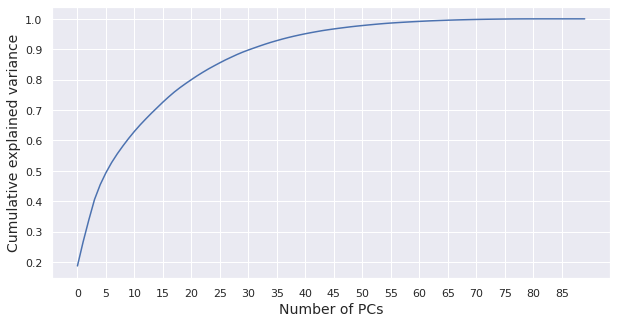

In [58]:
make_output_directory(Path("../results/pecto_dic/pca/pecto_dic/"), force=True, nodelete=True)
cumExpVar = plot_explained_variance(
    pd_pca,
    num_of_components,
    file_path="../results/pecto_dic/pca/pecto_dic/pd_pca_explained_variance.png",
)

In [59]:
print(f"{pd_pca.explained_variance_ratio_.sum() * 100}% of the variance in the data set was catpured by the PCA")

100.0% of the variance in the data set was catpured by the PCA


**Variance captured per PC:**

Explore the variance in the data that is captured by each PC.

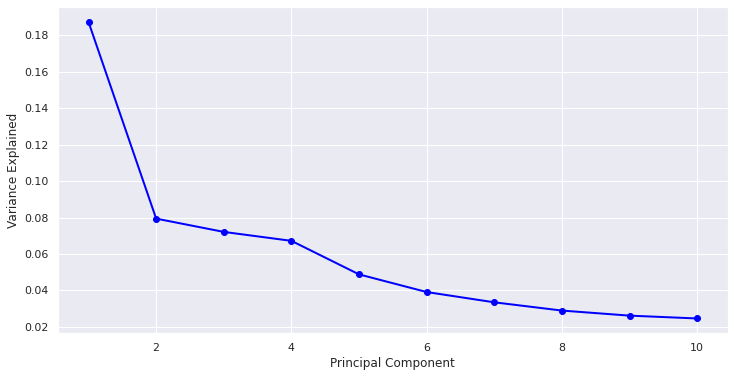

Explained variance for 1PC: 0.1873113881296023
Explained variance for 2PC: 0.07940755331408025
Explained variance for 3PC: 0.07211354517242904
Explained variance for 4PC: 0.06720664947463101
Explained variance for 5PC: 0.048798750804652596
Explained variance for 6PC: 0.039115720696905255
Explained variance for 7PC: 0.033473261214863693
Explained variance for 8PC: 0.028950202511867272
Explained variance for 9PC: 0.026170749328237236
Explained variance for 10PC: 0.024612376133605837


In [60]:
plot_scree(pd_pca, nComp=10, file_path="../results/pecto_dic/pca/pecto_dic/pd_pca_scree.png")

PC1 captures a signficantly greater amount degree of the varaince in the data set than all other PCs.  
PCs 2-4 capture comparable degrees of the variance

### Scatter and loadings plots

To explore the variance captured by each PC, plot different combinations of PCs onto a scatter plot where each axis represents a different PC and each point on the plot is a genome in the data set, using the `plot_pca()` function.

`plot_pca()` takes 6 positional argumets:
1. PCA object from `peform_pca()`
2. Scaling object (X_scaled) from `perform_pca()`
3. The dataframe of CAZy family frequencies, if you want to colour code the genomes by a specific grouping (i.e. by Genus), an additional column containing the grouping information needs to be added to the dataframe (e.g. listing the genus per genome)
4. The number of the first PC to be plotted, e.g. 1 for PC1 - int
5. The number of the second PC to be plotted, e.g. 2 for PC2 - int
6. The method to colour code the genomes by (e.g. 'Genus') - needs to match the name of the column containing the data in the dataframe of CAZy family frequencies

Owing to the majoirty of the variance captured by the PCA being captured by PCs 1-4, all possible combinations of these PCs were explored.

### PC1 vs PC2

Not applying hue order
Not Applying style


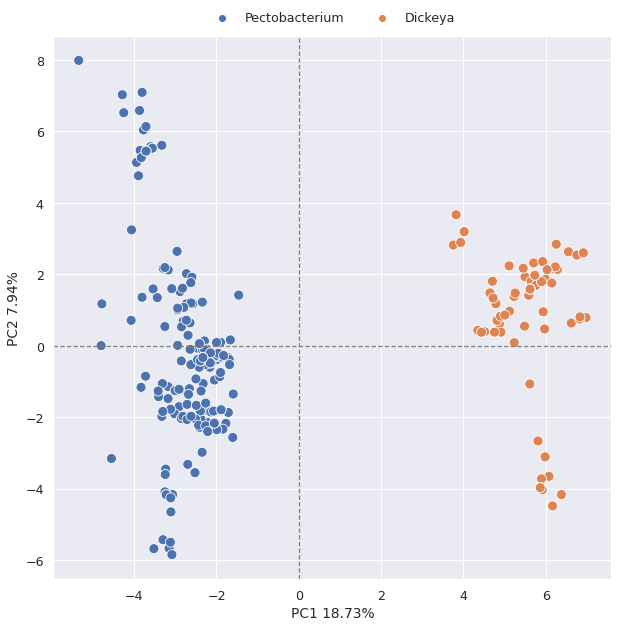

In [61]:
fam_freq_df_ggs['Genus'] = list(fam_freq_df_pd['Genus'])  # add column to use for colour scheme

pc1_pc2_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    1,
    2,
    'Genus',
    figsize=(10,10),
)

**Loadings plot:**

A loadings plot shows the degree of correlation between each variable (i.e. CAZy family) and each of the PCs.

### Plotting species classifications

### PC1 vs PC3

Not applying hue order
Not Applying style


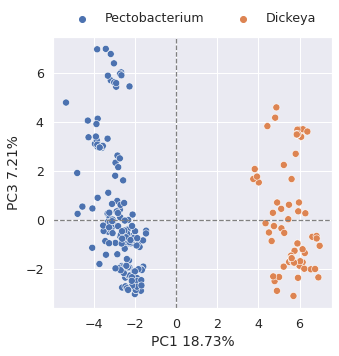

In [62]:
pc1_pc3_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    1,
    3,
    'Genus',
    figsize=(5,5),
    marker_size=50,
)

### PC1 vs PC4

Not applying hue order
Not Applying style


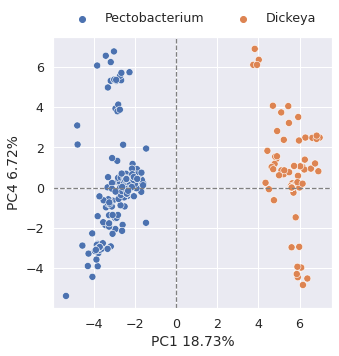

In [63]:
pc1_pc4_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    1,
    4,
    'Genus',
    figsize=(5,5),
    marker_size=50,
)

### PC2, PC3 and PC4

Not applying hue order
Not Applying style


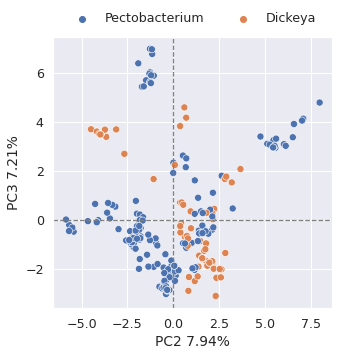

In [64]:
pc2_pc3_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    2,
    3,
    'Genus',
    figsize=(5,5),
    marker_size=50,
)

Not applying hue order
Not Applying style


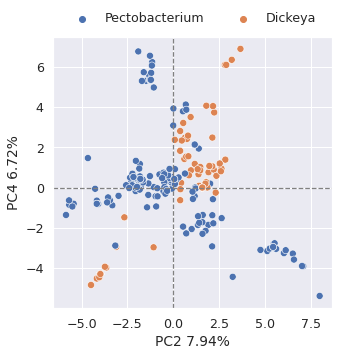

In [65]:
pc2_pc4_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    2,
    4,
    'Genus',
    figsize=(5,5),
    marker_size=50,
)

Not applying hue order
Not Applying style


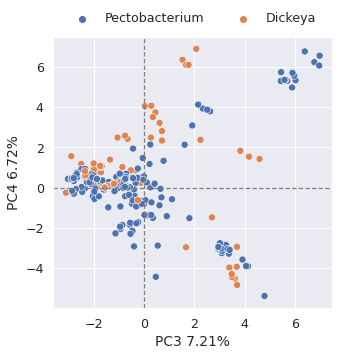

In [66]:
pc3_pc4_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    3,
    4,
    'Genus',
    figsize=(5,5),
    marker_size=50,
)

PC1 separates out the genomes in a manner that correlates with their genus classification: _Pectobacterium_ genomes are locataed in the negative PC1 axis, and _Dickeya_ genomes are located in the positive PC1 axis.

PCs 2-4 do not correlate with the genus classification.

### Species classification

To explore if PCs 2-4 correlated with the species classification for each genus, the _Pectobacterium_ and _Dickeya_ genomes were each subsetted, and the genomes projected onto all combinations of PCs 1-4, colour coding the genomes by the species classification.

In [67]:
help(plot_pca)

Help on function plot_pca in module cazomevolve.cazome.explore.pca:

plot_pca(pca, X_scaled, fam_df, first_pc, second_pc, group_by, file_path=None, style=None, style_order=None, hue_order=None, font_scale=1.15, figsize=None, xlim=None, ylim=None, dpi=300, loc='upper left', marker_size=100, markers=True)
    Project genomes onto the PCs
    
    :param pca: sklearn PCA object
    :param X_scaled: obj from scaling data
    :param fam_df: df of cazy family freqs
    :param first_pc: int, number of the first PC
    :param second_pc: int, number of the second PC
    :param group_by: how to group/colour data, genus or species
    
    OPTIONS
    :param file_path: path to write out fig, if none no file saved
    :param style: str, name of column to use to define style/marker style
    :param style_order: list order to list styles
    :param hue_order: list to write/assign categories of colours
    :param font_scale: float, scale font. >1 increases font size
    :param xlim: tuple, limits of 

Not applying hue order
Applying style
Not applying style order


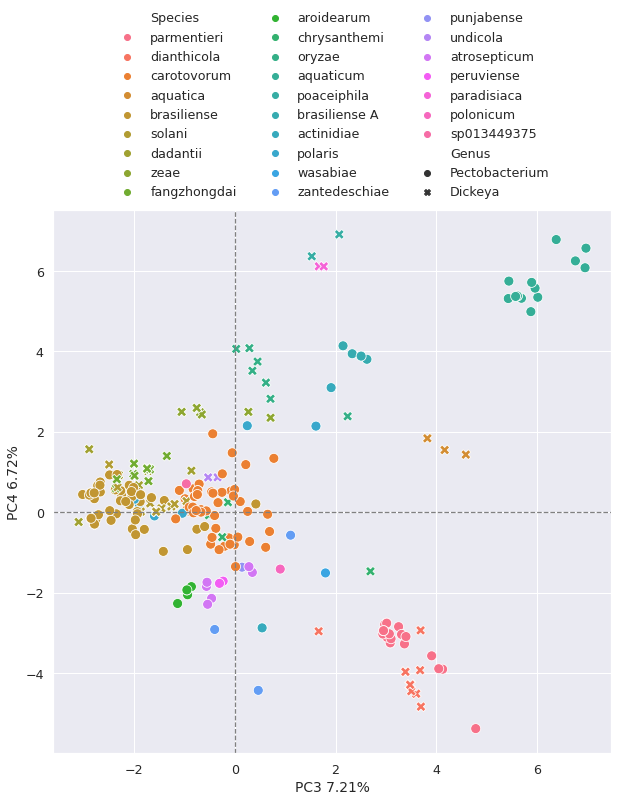

In [68]:
# subset the data
# and plot species classifications
fam_freq_df_ggs['Species'] = list(fam_freq_df_pd['Species'])  # add column to use for colour scheme
pc1_pc2_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    3,
    4,
    'Species',
    figsize=(10,10),
    style='Genus',
)

Split up the data onto separate plots, one plot per genus.

Not applying hue order
Applying style
Not applying style order


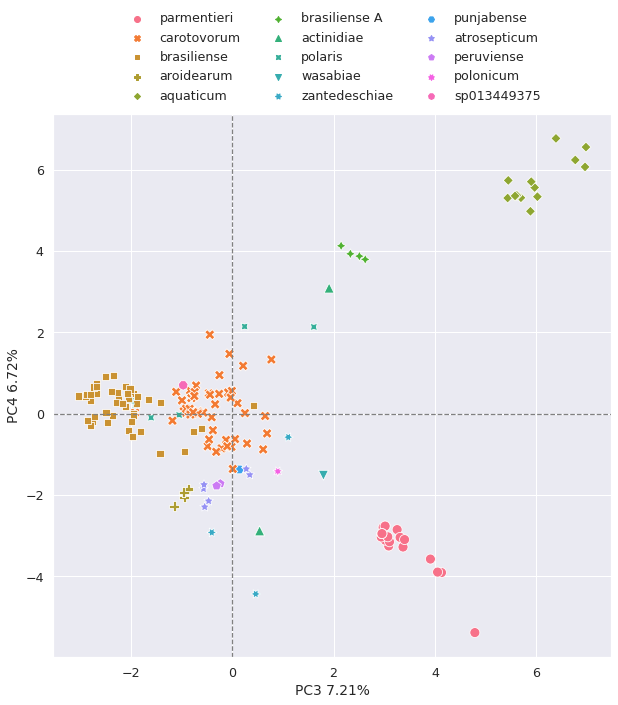

In [69]:
fam_freq_df_ggs['Species'] = list(fam_freq_df_pd['Species'])  # add column to use for colour scheme
sp_col = []
for i in range(len(fam_freq_df_ggs)):
    if fam_freq_df_ggs.iloc[i]['Genus'] == 'Dickeya':
        sp_col.append(None)
    else:
        sp_col.append(fam_freq_df_ggs.iloc[i]['Species'])
fam_freq_df_ggs['Species'] = sp_col
pc1_pc2_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    3,
    4,
    'Species',
    figsize=(10,10),
    style='Species',
)

Not applying hue order
Applying style
Not applying style order


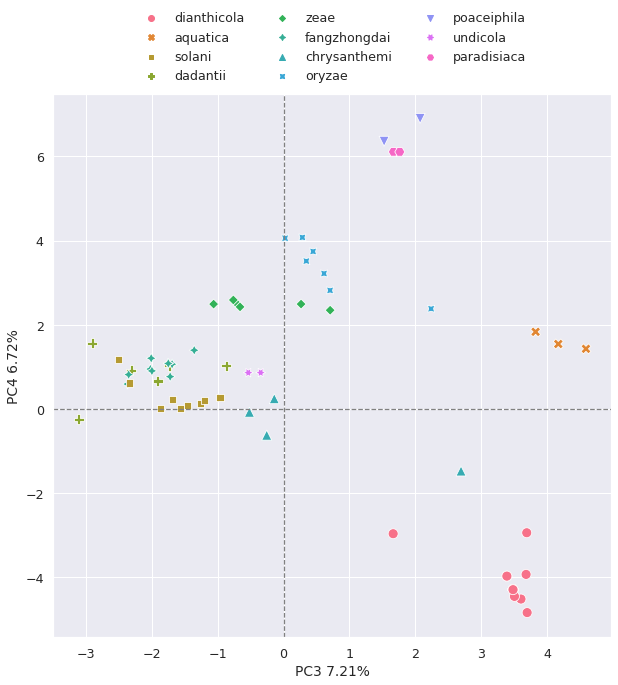

In [70]:
fam_freq_df_ggs['Species'] = list(fam_freq_df_pd['Species'])  # add column to use for colour scheme
sp_col = []
for i in range(len(fam_freq_df_ggs)):
    if fam_freq_df_ggs.iloc[i]['Genus'] == 'Pectobacterium':
        sp_col.append(None)
    else:
        sp_col.append(fam_freq_df_ggs.iloc[i]['Species'])
fam_freq_df_ggs['Species'] = sp_col
pc1_pc2_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    3,
    4,
    'Species',
    figsize=(10,10),
    style='Species',
)

Not applying hue order
Applying style
Not applying style order


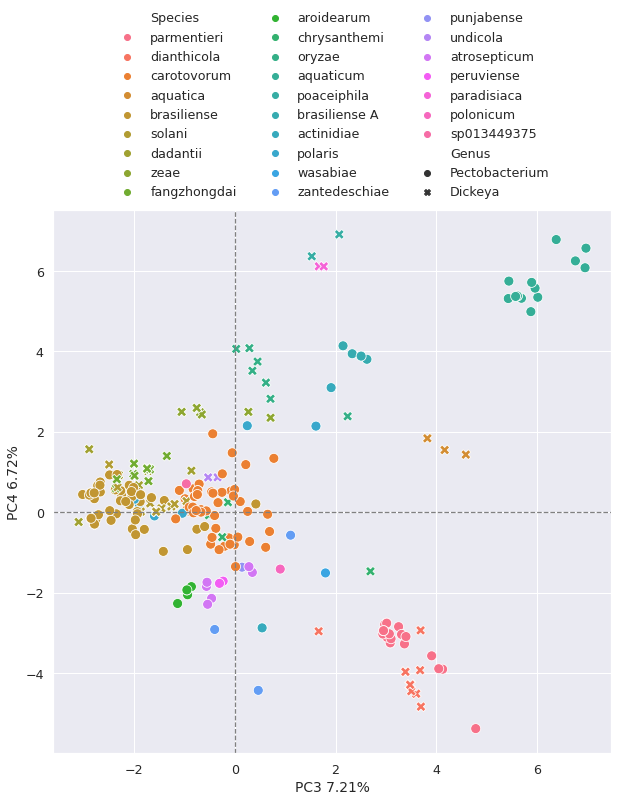

In [71]:
fam_freq_df_ggs['Species'] = list(fam_freq_df_pd['Species'])  # add column to use for colour scheme
pc1_pc2_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    3,
    4,
    'Species',
    figsize=(10,10),
    style='Genus',
)

In [72]:
pd_pca

PCA(n_components=90)

## 7. Genus specific PCA

Rerun the PCA but for only genomes from each of the genera.

In [73]:
# add column to separate genomes into respective genera
fam_freq_df_ggs['Genus'] = list(fam_freq_df_pd['Genus'])

# create one df for each genus
fam_freq_df_pecto = fam_freq_df_ggs[fam_freq_df_ggs['Genus'] == 'Pectobacterium']
fam_freq_df_dic = fam_freq_df_ggs[fam_freq_df_ggs['Genus'] == 'Dickeya']

# drop the Genus column so columns only contain numerical data
fam_freq_df_pecto = fam_freq_df_pecto.drop('Genus', axis=1)
fam_freq_df_dic = fam_freq_df_dic.drop('Genus', axis=1)

### _Pectobacterium_

In [74]:
# exclude species column from pca
pecto_num_of_components = len(fam_freq_df_pecto.columns[:-1])
pecto_pca, pecto_X_scaled = perform_pca(
    fam_freq_df_pecto[fam_freq_df_pecto.columns[:-1]],
    pecto_num_of_components,
)
pecto_pca

PCA(n_components=90)

Output directory ../results/pecto_dic/pca/pecto exists, nodelete is True. Adding output to output directory.


Number of features needed to explain 0.95 fraction of total variance is 34. 


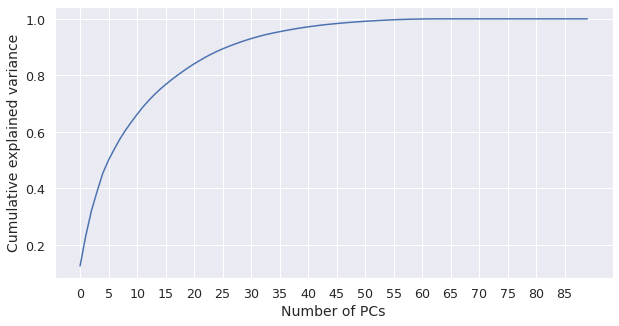

In [75]:
make_output_directory(Path("../results/pecto_dic/pca/pecto/"), force=True, nodelete=True)
cumExpVar = plot_explained_variance(
    pecto_pca,
    pecto_num_of_components,
    file_path="../results/pecto_dic/pca/pecto/pecto_explained_variance.png",
)

In [76]:
print(f"{pecto_pca.explained_variance_ratio_.sum() * 100}% of the variance in the data set was catpured by the PCA")

100.0% of the variance in the data set was catpured by the PCA


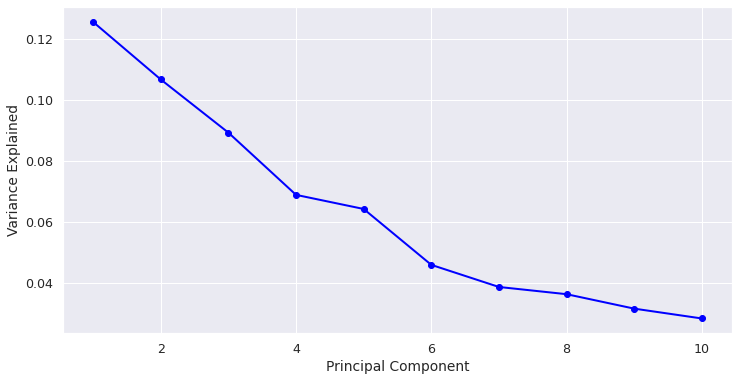

Explained variance for 1PC: 0.12541422774455632
Explained variance for 2PC: 0.10658682173685914
Explained variance for 3PC: 0.08917501997054028
Explained variance for 4PC: 0.06881025175614182
Explained variance for 5PC: 0.06419102909159952
Explained variance for 6PC: 0.045895883256945304
Explained variance for 7PC: 0.03865789026360112
Explained variance for 8PC: 0.03629461821919456
Explained variance for 9PC: 0.031563805140827905
Explained variance for 10PC: 0.028344839095695025


In [77]:
plot_scree(pecto_pca, nComp=10, file_path="../results/pecto_dic/pca/pecto/pecto_scree_plot.png")

Not applying hue order
Applying style
Not applying style order


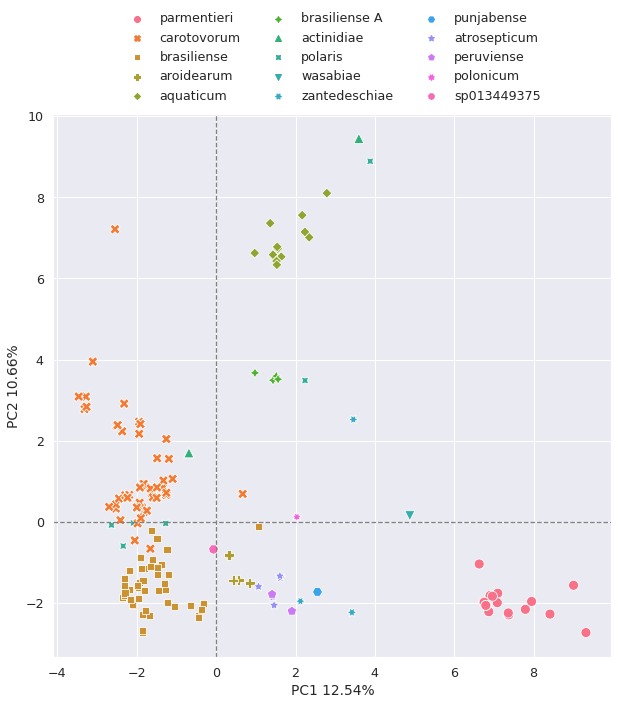

In [78]:
fam_freq_df_ggs['Species'] = list(fam_freq_df_pd['Species'])  # add column to use for colour scheme
temp_df = fam_freq_df_ggs[fam_freq_df_ggs['Genus'] == 'Pectobacterium']
fam_freq_df_pecto['Species'] = list(temp_df['Species'])

pc1_pc2_scatter_plt = plot_pca(
    pecto_pca,
    pecto_X_scaled,
    fam_freq_df_pecto,
    1,
    2,
    'Species',
    style='Species',
    figsize=(10,10),
    file_path="../results/pecto_dic/pca/pecto/pecto_pc1_pc2.png",
)

Not applying hue order
Applying style
Not applying style order


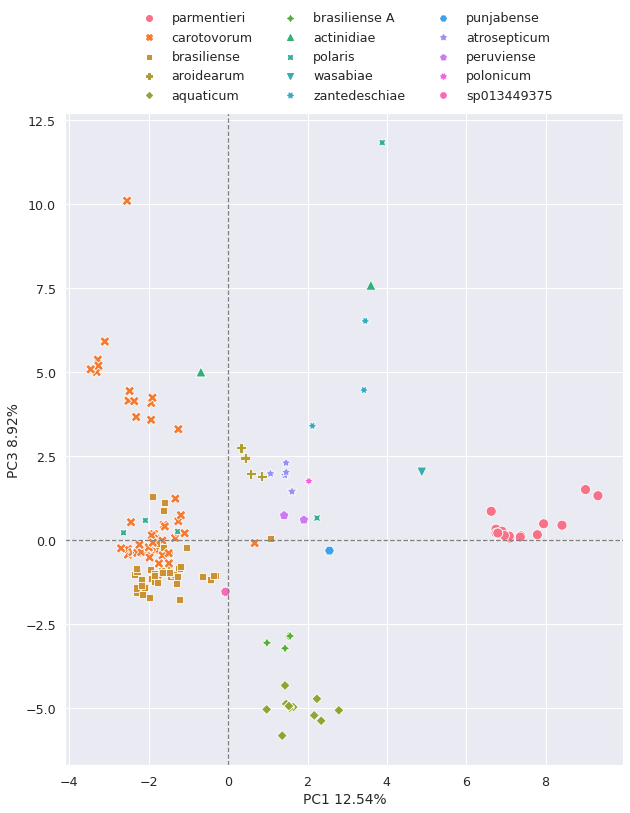

In [79]:
pc1_pc3_scatter_plt = plot_pca(
    pecto_pca,
    pecto_X_scaled,
    fam_freq_df_pecto,
    1,
    3,
    'Species',
    style='Species',
    figsize=(10,12),
    file_path="../results/pecto_dic/pca/pecto/pecto_pc1_pc3.png",
)

Not applying hue order
Applying style
Not applying style order


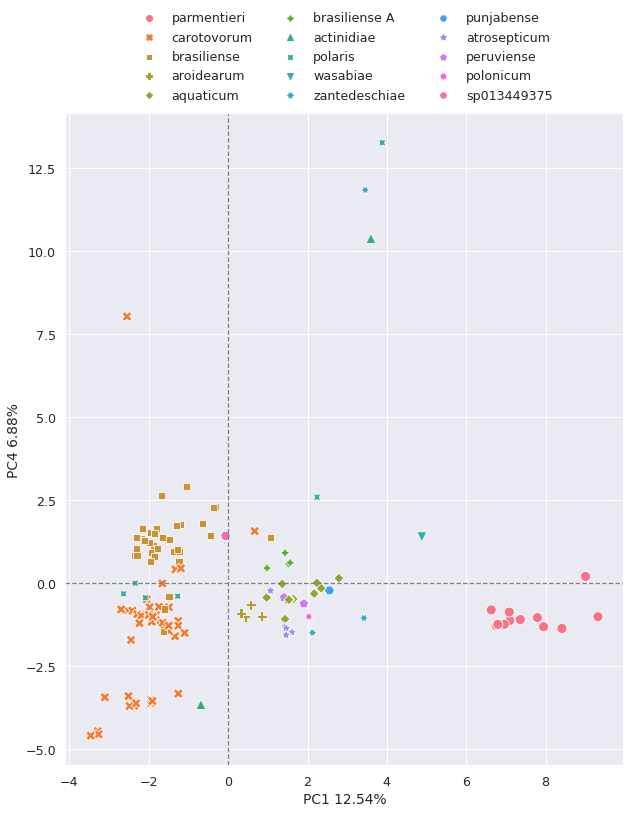

In [80]:
pc1_pc4_scatter_plt = plot_pca(
    pecto_pca,
    pecto_X_scaled,
    fam_freq_df_pecto,
    1,
    4,
    'Species',
    style='Species',
    figsize=(10,12),
    file_path="../results/pecto_dic/pca/pecto/pecto_pc1_pc4.png",
)

Not applying hue order
Applying style
Not applying style order


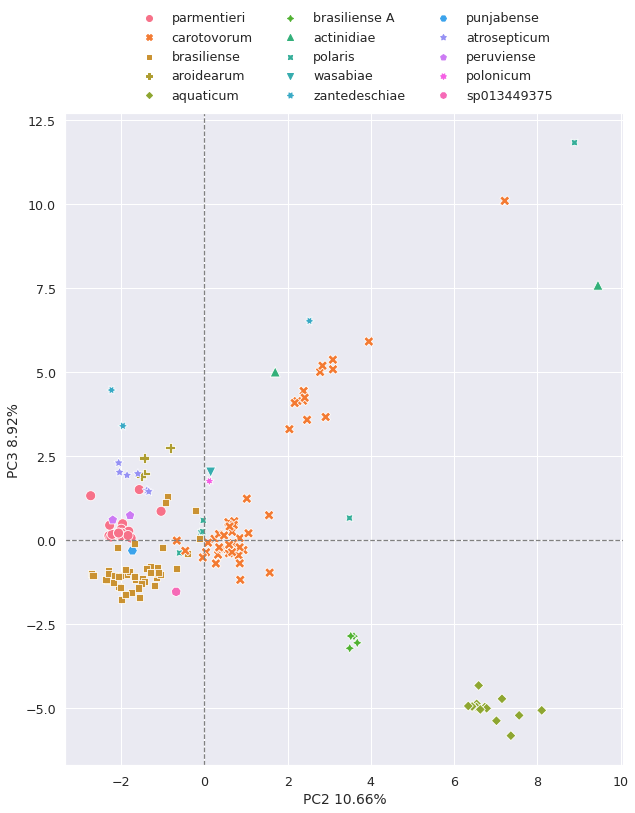

In [81]:
pc2_pc3_scatter_plt = plot_pca(
    pecto_pca,
    pecto_X_scaled,
    fam_freq_df_pecto,
    2,
    3,
    'Species',
    style='Species',
    figsize=(10,12),
    file_path="../results/pecto_dic/pca/pecto/pecto_pc2_pc3.png",
)

Not applying hue order
Applying style
Not applying style order


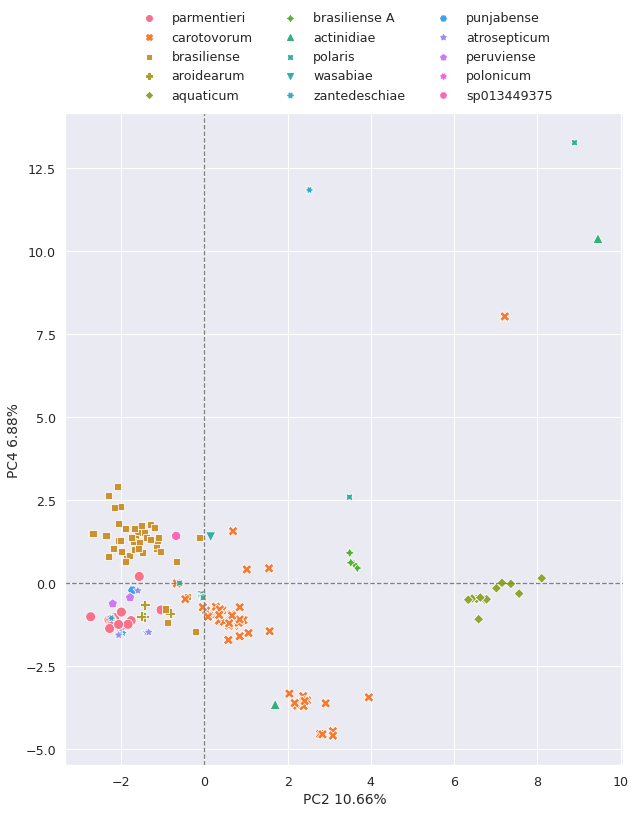

In [82]:
pc2_pc4_scatter_plt = plot_pca(
    pecto_pca,
    pecto_X_scaled,
    fam_freq_df_pecto,
    2,
    4,
    'Species',
    style='Species',
    figsize=(10,12),
    file_path="../results/pecto_dic/pca/pecto/pecto_pc2_pc4.png",
)

Not applying hue order
Applying style
Not applying style order


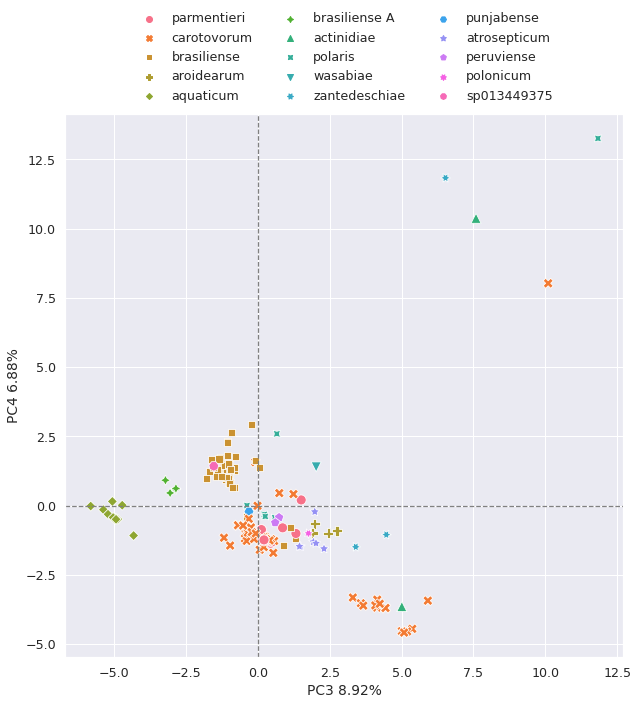

In [83]:
pc3_pc4_scatter_plt = plot_pca(
    pecto_pca,
    pecto_X_scaled,
    fam_freq_df_pecto,
    3,
    4,
    'Species',
    style='Species',
    figsize=(10,10),
    file_path="../results/pecto_dic/pca/pecto/pecto_pc3_pc4.png",
)

The _P.carotovorum_ species repeated splits into two groups or clusters on the above PCA plots.

Annotate the genomes and look at the phylogenetic tree.

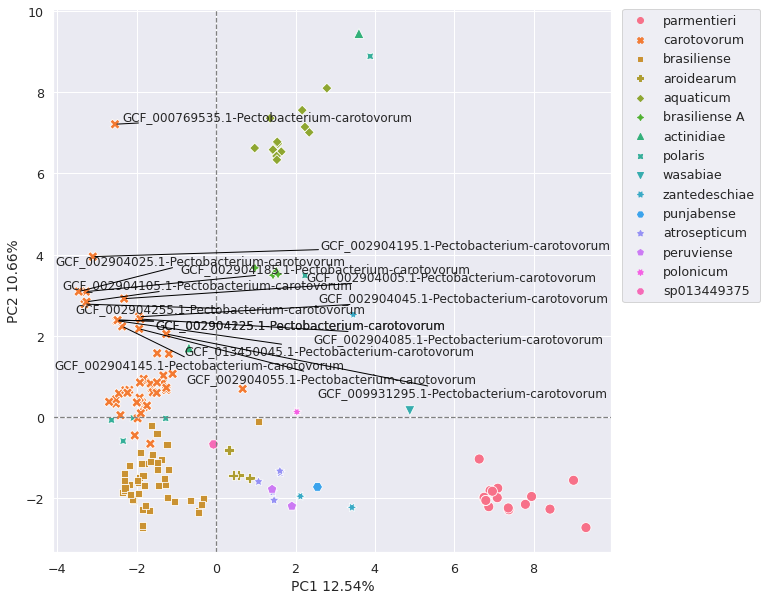

In [84]:
X_pca = pecto_pca.transform(pecto_X_scaled)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.15)

g = sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    data=fam_freq_df_pecto,
    hue='Species',
    style='Species',
    s=100,
    markers=True,
)

g.axhline(0, linestyle='--', color='grey', linewidth=1.25);
g.axvline(0, linestyle='--', color='grey', linewidth=1.25);

plt.ylabel(f"PC2 {100 * pecto_pca.explained_variance_ratio_[1]:.2f}%");
plt.xlabel(f"PC1 {100 * pecto_pca.explained_variance_ratio_[0]:.2f}%");
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

genome_lbls = ["-".join(_) for _ in fam_freq_df_pecto.index]
x_vals = X_pca[:,0]
y_vals = X_pca[:,1]

texts = [
    plt.text(
        xval,
        yval,
        lbl,
        ha='center',
        va='center',
        fontsize=12,
    ) for (xval, yval, lbl) in zip(
        x_vals, y_vals, genome_lbls
    ) if ((yval > 2) and (xval < 0))
]
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'));

plt.savefig('../results/pecto_dic/pca/pecto/pecto_pc1_pc2_LABELLED.png', bbox_inches='tight', format='png')

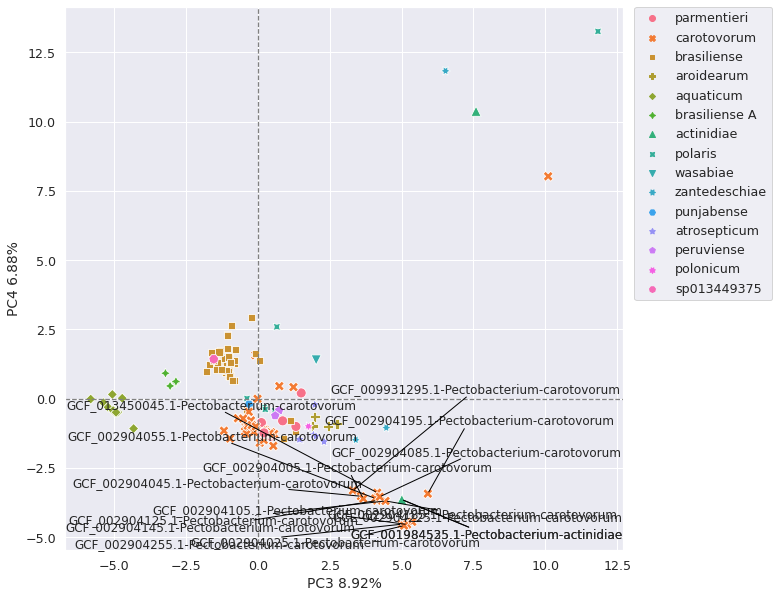

In [85]:
X_pca = pecto_pca.transform(pecto_X_scaled)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.15)

g = sns.scatterplot(
    x=X_pca[:,2],
    y=X_pca[:,3],
    data=fam_freq_df_pecto,
    hue='Species',
    style='Species',
    s=100,
    markers=True,
)

g.axhline(0, linestyle='--', color='grey', linewidth=1.25);
g.axvline(0, linestyle='--', color='grey', linewidth=1.25);

plt.xlabel(f"PC3 {100 * pecto_pca.explained_variance_ratio_[2]:.2f}%");
plt.ylabel(f"PC4 {100 * pecto_pca.explained_variance_ratio_[3]:.2f}%");
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

genome_lbls = ["-".join(_) for _ in fam_freq_df_pecto.index]
x_vals = X_pca[:,2]
y_vals = X_pca[:,3]

texts = [
    plt.text(
        xval,
        yval,
        lbl,
        ha='center',
        va='center',
        fontsize=12,
    ) for (xval, yval, lbl) in zip(
        x_vals, y_vals, genome_lbls
    ) if ((yval < -2.5) and (xval > 2.5))
]
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'));

plt.savefig('../results/pecto_dic/pca/pecto/pecto_pc3_pc4_LABELLED.png', bbox_inches='tight', format='png')

### Dickeya

In [86]:
dic_num_of_components = len(fam_freq_df_dic.columns[:-1])
dic_pca, dic_X_scaled = perform_pca(
    fam_freq_df_dic[fam_freq_df_dic.columns[:-1]],
    dic_num_of_components,
)
dic_pca

PCA(n_components=90)

Output directory ../results/pecto_dic/pca/dickeya exists, nodelete is True. Adding output to output directory.


Number of features needed to explain 0.95 fraction of total variance is 23. 


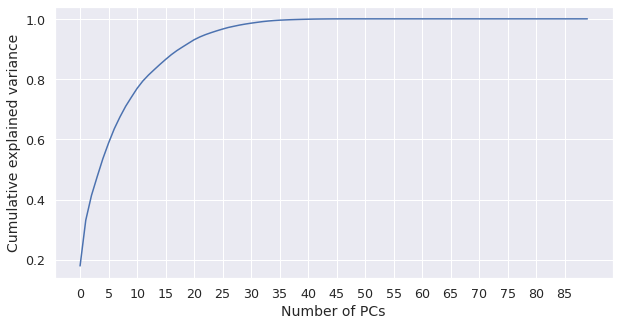

In [87]:
make_output_directory(Path("../results/pecto_dic/pca/dickeya/"), force=True, nodelete=True)

cumExpVar = plot_explained_variance(
    dic_pca,
    dic_num_of_components,
    file_path="../results/pecto_dic/pca/dickeya/dic_explained_variance.png",
)

In [88]:
print(f"{dic_pca.explained_variance_ratio_.sum() * 100}% of the variance in the data set was catpured by the PCA")

100.0% of the variance in the data set was catpured by the PCA


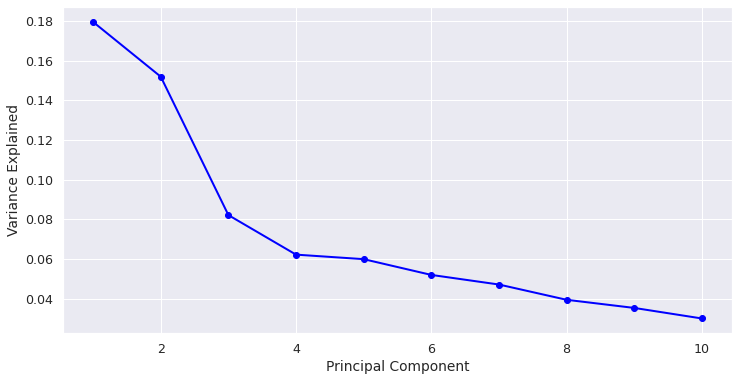

Explained variance for 1PC: 0.17943197554028859
Explained variance for 2PC: 0.15185277188438745
Explained variance for 3PC: 0.08213842955084184
Explained variance for 4PC: 0.06222640267540776
Explained variance for 5PC: 0.05994818836300484
Explained variance for 6PC: 0.05200514373406153
Explained variance for 7PC: 0.0471663932225993
Explained variance for 8PC: 0.03947640898113394
Explained variance for 9PC: 0.035378060074272855
Explained variance for 10PC: 0.030065897524545436


In [89]:
plot_scree(dic_pca, nComp=10, file_path="../results/pecto_dic/pca/dickeya/dic_scree_plot.png")

Not applying hue order
Applying style
Not applying style order


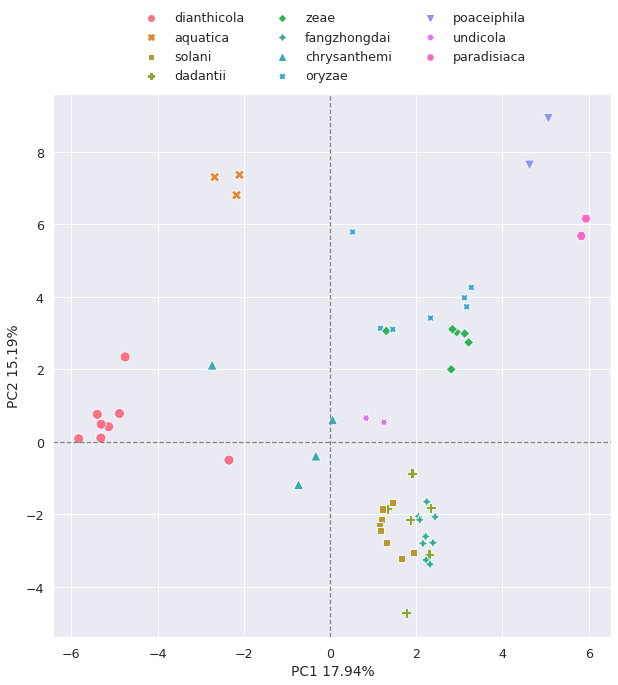

In [90]:
fam_freq_df_ggs['Species'] = list(fam_freq_df_pd['Species'])  # add column to use for colour scheme
temp_df = fam_freq_df_ggs[fam_freq_df_ggs['Genus'] == 'Dickeya']
fam_freq_df_dic['Species'] = list(temp_df['Species'])

pc1_pc2_scatter_plt = plot_pca(
    dic_pca,
    dic_X_scaled,
    fam_freq_df_dic,
    1,
    2,
    'Species',
    style='Species',
    figsize=(10,10),
    file_path="../results/pecto_dic/pca/dickeya/dic_pc1_pc2.png",
)

Not applying hue order
Applying style
Not applying style order


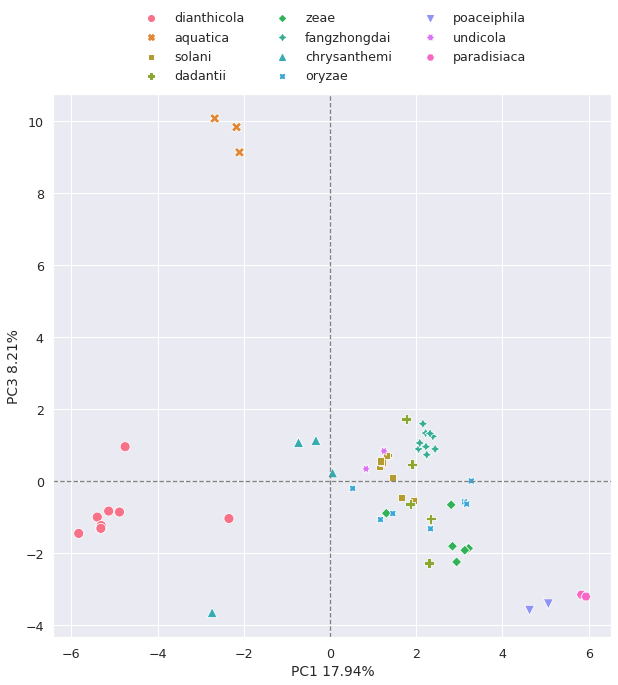

In [91]:
pc1_pc3_scatter_plt = plot_pca(
    dic_pca,
    dic_X_scaled,
    fam_freq_df_dic,
    1,
    3,
    'Species',
    style='Species',
    figsize=(10,10),
    file_path="../results/pecto_dic/pca/dickeya/dic_pc1_pc3.png",
)

Not applying hue order
Applying style
Not applying style order


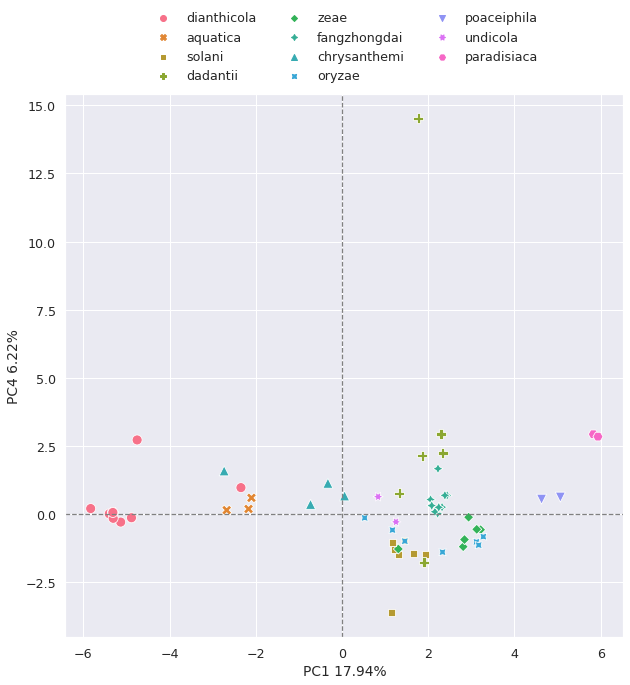

In [92]:
pc1_pc4_scatter_plt = plot_pca(
    dic_pca,
    dic_X_scaled,
    fam_freq_df_dic,
    1,
    4,
    'Species',
    style='Species',
    figsize=(10,10),
    file_path="../results/pecto_dic/pca/dickeya/dic_pc1_pc4.png",
)

Not applying hue order
Applying style
Not applying style order


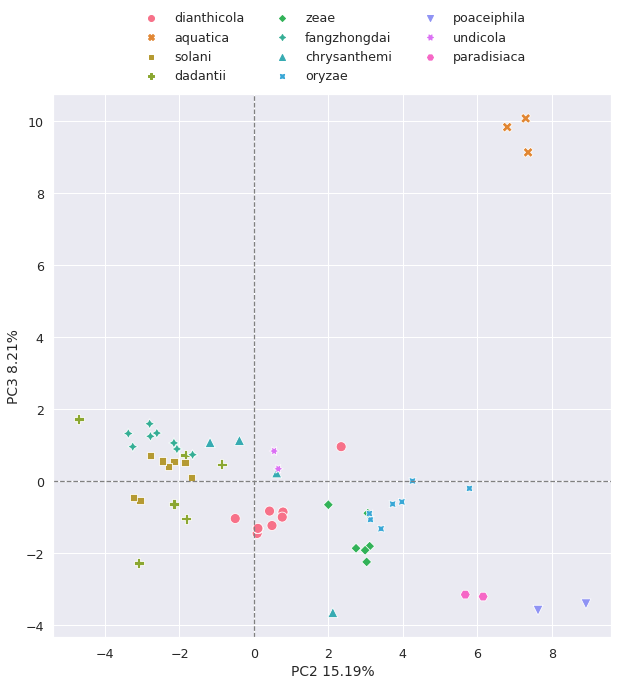

In [93]:
pc2_pc3_scatter_plt = plot_pca(
    dic_pca,
    dic_X_scaled,
    fam_freq_df_dic,
    2,
    3,
    'Species',
    style='Species',
    figsize=(10,10),
    file_path="../results/pecto_dic/pca/dickeya/dic_pc2_pc3.png",
)

Not applying hue order
Applying style
Not applying style order


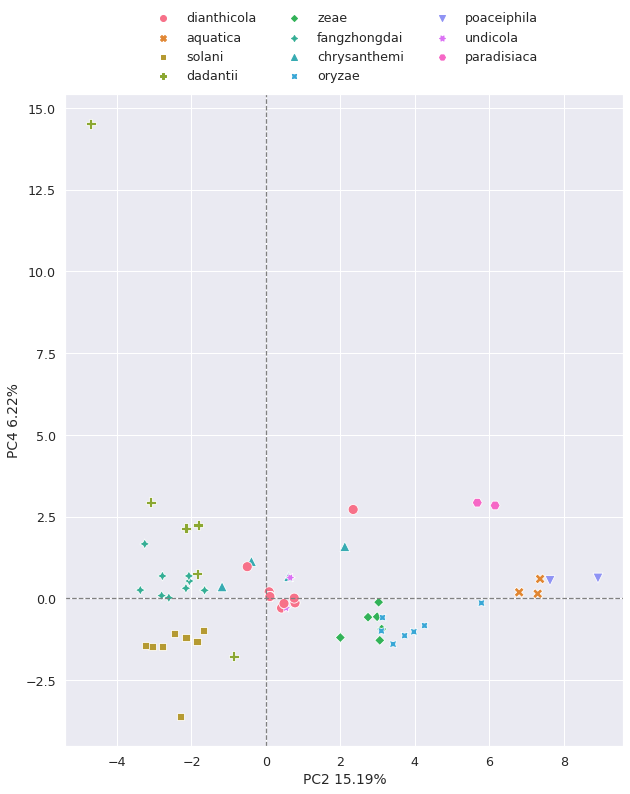

In [94]:
pc2_pc4_scatter_plt = plot_pca(
    dic_pca,
    dic_X_scaled,
    fam_freq_df_dic,
    2,
    4,
    'Species',
    style='Species',
    figsize=(10,12),
    file_path="../results/pecto_dic/pca/dickeya/dic_pc2_pc4.png",
)

Not applying hue order
Applying style
Not applying style order


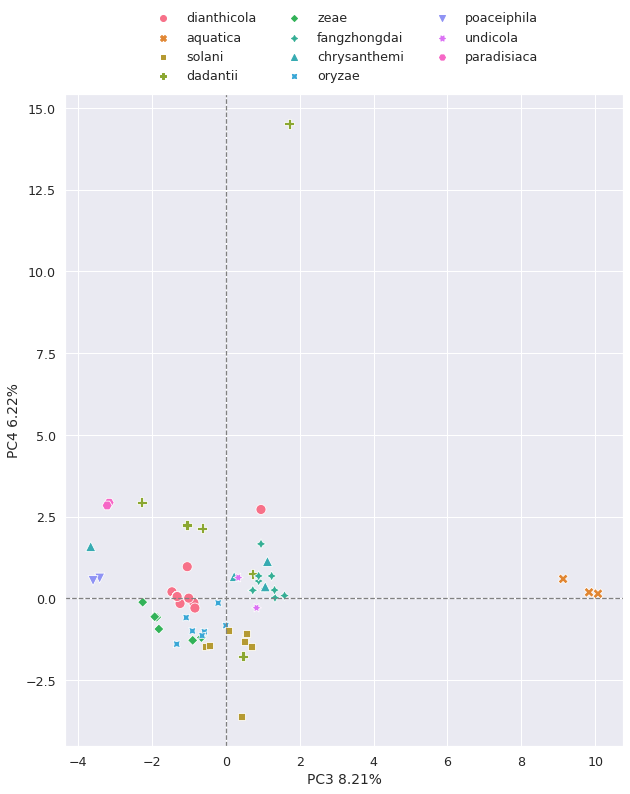

In [95]:
pc3_pc4_scatter_plt = plot_pca(
    dic_pca,
    dic_X_scaled,
    fam_freq_df_dic,
    3,
    4,
    'Species',
    style='Species',
    figsize=(10,12),
    file_path="../results/pecto_dic/pca/dickeya/dic_pc3_pc4.png",
)

PC4 separated out one _dadantii_ genome from all other _Dickeya_ genomes.

Regenerate the plot and label the genome.

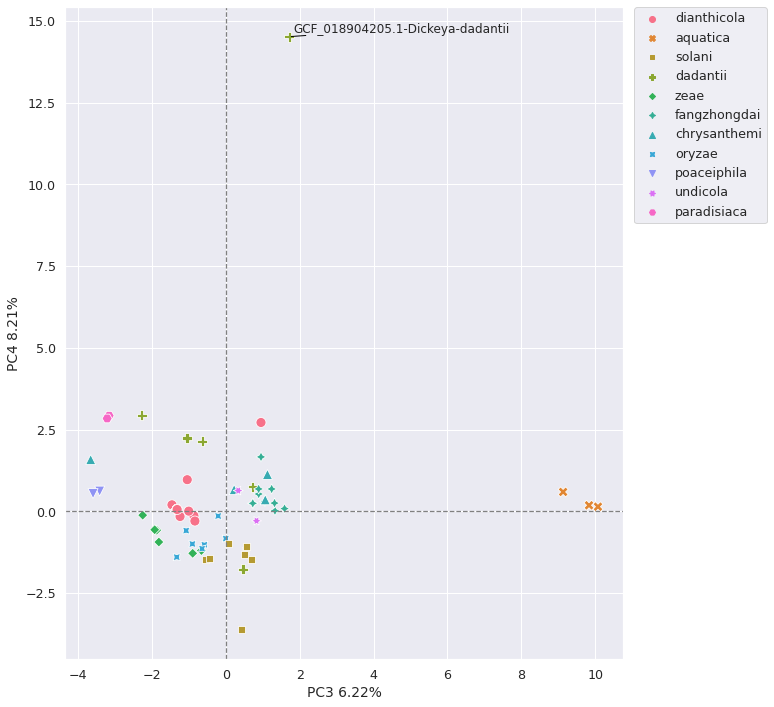

In [96]:
X_pca = dic_pca.transform(dic_X_scaled)

plt.figure(figsize=(10,12))
sns.set(font_scale=1.15)

g = sns.scatterplot(
    x=X_pca[:,2],
    y=X_pca[:,3],
    data=fam_freq_df_dic,
    hue='Species',
    style='Species',
    s=100,
    markers=True,
)

g.axhline(0, linestyle='--', color='grey', linewidth=1.25);
g.axvline(0, linestyle='--', color='grey', linewidth=1.25);

plt.ylabel(f"PC4 {100 * dic_pca.explained_variance_ratio_[2]:.2f}%");
plt.xlabel(f"PC3 {100 * dic_pca.explained_variance_ratio_[3]:.2f}%");
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

genome_lbls = ["-".join(_) for _ in fam_freq_df_dic.index]
x_vals = X_pca[:,2]
y_vals = X_pca[:,3]

texts = [
    plt.text(
        xval,
        yval,
        lbl,
        ha='center',
        va='center',
        fontsize=12,
    ) for (xval, yval, lbl) in zip(
        x_vals, y_vals, genome_lbls
    ) if (yval > 12)
]
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'));

plt.savefig('../results/pecto_dic/pca/dickeya/dic_pc3_pc4_LABELLED.png', bbox_inches='tight', format='png')

Looking at the phylogenetic tree (which was reconstructed from SCOs by RaxML-NG), the _D.dadantii_ genome that is placed in isolation, is clustered with the other genomes from its species in the tree. However, the GCA\_018904205.1 genome was on a separate branch from the other genomes, and on a branch that diverged earlier.